In [ ]:
# imports & small helpers
import os, math, time, glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torch.amp import autocast, GradScaler
from tqdm.notebook import tqdm
import h5py, scipy.io, numpy as np, math, os
import matplotlib.pyplot as plt
from scipy import ndimage
import csv

plt.rcParams['figure.figsize'] = (8,4)

# reproducible
torch.manual_seed(42)
np.random.seed(42)

# small metric helpers
def pixel_accuracy(pred_logits, target, ignore_index=255):
    # pred_logits (B, C, H, W) or pred labels (B, H, W)
    if pred_logits.ndim == 4:
        preds = pred_logits.argmax(dim=1)
    else:
        preds = pred_logits
    valid = (target != ignore_index)
    if valid.sum().item() == 0:
        return float('nan')
    correct = ((preds == target) & valid).sum().item()
    total = valid.sum().item()
    return correct / (total + 1e-12)

def rmse_from_classes(pred_logits, target_classes, bin_size=1.0, ignore_index=255):
    pred_cls = pred_logits.argmax(dim=1)
    valid = (target_classes != ignore_index)
    if valid.sum().item() == 0:
        return float('nan')
    pred_h = (pred_cls.float() * bin_size)[valid]
    target_h = (target_classes.float() * bin_size)[valid]
    mse = ((pred_h - target_h)**2).mean().item()
    return math.sqrt(mse)


In [ ]:
# load processed npz
npz_path = "processed_tomosar_features.npz"   
assert os.path.exists(npz_path), f"{npz_path} not found. Save it first."

data = np.load(npz_path)
features_all = data["X"]        # (H, W, C)
CHM_q = data["CHM"]             # (H, W), quantized classes or 255
DTM_q = data["DTM"]
valid_mask = data["mask"].astype(bool)

print("Loaded shapes:", features_all.shape, CHM_q.shape, DTM_q.shape, valid_mask.shape)

# dataset class
class TomoSARFullGridDataset(torch.utils.data.Dataset):
    def __init__(self, features, chm_labels, dtm_labels, valid_mask,
                 patch_size=64, use_coords=True, normalize=True, ignore_index=255):
        self.X = features.transpose(2,0,1)  # (C,H,W)
        self.y_chm = chm_labels
        self.y_dtm = dtm_labels
        self.valid = valid_mask
        self.patch_size = patch_size
        self.half = patch_size//2
        self.use_coords = use_coords
        self.ignore_index = ignore_index
        self.C, self.H, self.W = self.X.shape

        # centers only on valid mask
        self.centers = [(y,x) for y in range(self.H) for x in range(self.W) if self.valid[y,x]]

        # normalization computed over valid pixels
        if normalize:
            vals = self.X[:, self.valid].T  # shape (n_valid, C)
            self.mean = vals.mean(axis=0).astype(np.float32)
            self.std = (vals.std(axis=0) + 1e-6).astype(np.float32)
        else:
            self.mean = np.zeros(self.C, np.float32)
            self.std = np.ones(self.C, np.float32)

    def __len__(self):
        return len(self.centers)

    def __getitem__(self, idx):
        cy,cx = self.centers[idx]
        top,left = cy-self.half, cx-self.half
        patch_x = self._pad_and_crop(self.X, top, left)  # (C, P, P)
        patch_chm = self._pad_and_crop(self.y_chm[None], top, left)[0]
        patch_dtm = self._pad_and_crop(self.y_dtm[None], top, left)[0]

        # normalize
        patch_x = (patch_x - self.mean[:,None,None]) / self.std[:,None,None]

        # coords
        if self.use_coords:
            yy, xx = np.meshgrid(np.linspace(-1,1,self.patch_size), np.linspace(-1,1,self.patch_size), indexing='ij')
            patch_x = np.concatenate([patch_x, yy[None], xx[None]], axis=0)

        # clip labels to valid ranges
        patch_chm = np.where((patch_chm>=0)&(patch_chm<=60), patch_chm, self.ignore_index)
        patch_dtm = np.where((patch_dtm>=0)&(patch_dtm<=40), patch_dtm, self.ignore_index)

        return {
            "x": torch.from_numpy(patch_x.astype(np.float32)),
            "chm": torch.from_numpy(patch_chm.astype(np.int64)),
            "dtm": torch.from_numpy(patch_dtm.astype(np.int64))
        }

    def _pad_and_crop(self, arr, top, left):
        C,H,W = arr.shape
        bottom, right = top + self.patch_size, left + self.patch_size
        top_clip, left_clip = max(0, top), max(0, left)
        bottom_clip, right_clip = min(H, bottom), min(W, right)
        patch = arr[:, top_clip:bottom_clip, left_clip:right_clip]
        pad_top = max(0, -top)
        pad_left = max(0, -left)
        pad_bottom = max(0, bottom - H)
        pad_right = max(0, right - W)
        if any([pad_top, pad_left, pad_bottom, pad_right]):
            patch = np.pad(patch, ((0,0),(pad_top,pad_bottom),(pad_left,pad_right)), mode='reflect')
        return patch

# construct dataset
patch_size = 64
use_coords = True
dataset = TomoSARFullGridDataset(features_all, CHM_q, DTM_q, valid_mask, patch_size=patch_size, use_coords=use_coords, normalize=True)
print("Dataset length (valid centers):", len(dataset))
print("Channels (before coords):", features_all.shape[2], "after coords:", dataset.X.shape[0] + (2 if use_coords else 0))


Loaded shapes: (2450, 1428, 70) (2450, 1428) (2450, 1428) (2450, 1428)
Dataset length (valid centers): 2555060
Channels (before coords): 70 after coords: 72


In [ ]:
## UNetMultiHead with 4 encoders + bottleneck + 4 decoders
import torch.nn as nn
import torch

class UNetMultiHead(nn.Module):
    def __init__(self, in_ch, chm_classes=61, dtm_classes=41, base=32):
        """
        4-level encoder / bottleneck / 4-level decoder UNet.
        in_ch : number of input channels (70 or 72 if coords added)
        base  : base number of filters (32 is common)
        """
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        # encoder
        self.enc1 = conv_block(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(base*4, base*8)
        self.pool4 = nn.MaxPool2d(2)

        # bottleneck / center
        self.center = conv_block(base*8, base*16)

        # decoder (mirror)
        self.up4 = nn.ConvTranspose2d(base*16, base*8, kernel_size=2, stride=2)
        self.dec4 = conv_block(base*16, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, kernel_size=2, stride=2)
        self.dec3 = conv_block(base*8, base*4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, kernel_size=2, stride=2)
        self.dec2 = conv_block(base*4, base*2)

        self.up1 = nn.ConvTranspose2d(base*2, base, kernel_size=2, stride=2)
        self.dec1 = conv_block(base*2, base)

        # heads
        self.out_chm = nn.Conv2d(base, chm_classes, kernel_size=1)
        self.out_dtm = nn.Conv2d(base, dtm_classes, kernel_size=1)

        # initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # encoder
        e1 = self.enc1(x)           # (B, base, H, W)
        e2 = self.enc2(self.pool1(e1))  # (B, base*2, H/2, W/2)
        e3 = self.enc3(self.pool2(e2))  # (B, base*4, H/4, W/4)
        e4 = self.enc4(self.pool3(e3))  # (B, base*8, H/8, W/8)

        # center
        c = self.center(self.pool4(e4)) # (B, base*16, H/16, W/16)

        # decoder
        d4 = self.up4(c)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out_chm = self.out_chm(d1)
        out_dtm = self.out_dtm(d1)
        return out_chm, out_dtm


In [ ]:
# training function
from torch.amp import autocast, GradScaler
def train_and_save(
    dataset,
    out_dir="checkpoints",
    epochs=100,
    batch_size=16,
    lr=1e-4,
    device=None,
    val_ratio=0.1,
    test_ratio=0.1,
    base=32,
    patience=6,
    save_every_epoch=True
):
    os.makedirs(out_dir, exist_ok=True)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # deterministic split
    total = len(dataset)
    val_len = int(total * val_ratio)
    test_len = int(total * test_ratio)
    train_len = total - val_len - test_len
    train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))
    print("Split sizes: train, val, test =", len(train_ds), len(val_ds), len(test_ds))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    # infer input channels
    in_ch = dataset.X.shape[0] + (2 if dataset.use_coords else 0)
    model = UNetMultiHead(in_ch=in_ch, base=base).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=4)
    scaler = GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    # trackers
    history = {"train_loss": [], "val_loss": [], "val_acc_chm": [], "val_acc_dtm": [], "val_rmse_chm": [], "val_rmse_dtm": []}

    for epoch in range(1, epochs+1):
        t0 = time.time()
        model.train()
        running_loss = 0.0
        n_samples = 0

        #pbar = tqdm(train_loader, desc=f"Train {epoch}/{epochs}", leave=False)
        for batch in train_loader:
            x = batch["x"].to(device)
            y_chm = batch["chm"].to(device)
            y_dtm = batch["dtm"].to(device)

            # skip batches with zero valid pixels in either head
            if (y_chm != 255).sum() == 0 or (y_dtm != 255).sum() == 0:
                continue

            optimizer.zero_grad()
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                pred_chm, pred_dtm = model(x)
                loss = criterion(pred_chm, y_chm) + 0.5 * criterion(pred_dtm, y_dtm)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * x.size(0)
            n_samples += x.size(0)
            #pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        epoch_train_loss = running_loss / (n_samples + 1e-12)
        history["train_loss"].append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        acc_chm = 0.0
        acc_dtm = 0.0
        rmse_chm = 0.0
        rmse_dtm = 0.0
        val_samples = 0
        with torch.no_grad():
            for batch in val_loader:                       #tqdm(val_loader, desc=f"Validate {epoch}/{epochs}", leave=False):
                x = batch["x"].to(device)
                y_chm = batch["chm"].to(device)
                y_dtm = batch["dtm"].to(device)

                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                    p_chm, p_dtm = model(x)
                    loss = criterion(p_chm, y_chm) + 0.5 * criterion(p_dtm, y_dtm)

                val_loss += loss.item() * x.size(0)
                acc_chm += pixel_accuracy(p_chm, y_chm) * x.size(0)
                acc_dtm += pixel_accuracy(p_dtm, y_dtm) * x.size(0)
                rmse_chm += rmse_from_classes(p_chm, y_chm) * x.size(0)
                rmse_dtm += rmse_from_classes(p_dtm, y_dtm) * x.size(0)
                val_samples += x.size(0)

        val_loss = val_loss / (val_samples + 1e-12)
        acc_chm = acc_chm / (val_samples + 1e-12)
        acc_dtm = acc_dtm / (val_samples + 1e-12)
        rmse_chm = rmse_chm / (val_samples + 1e-12)
        rmse_dtm = rmse_dtm / (val_samples + 1e-12)

        history["val_loss"].append(val_loss)
        history["val_acc_chm"].append(acc_chm)
        history["val_acc_dtm"].append(acc_dtm)
        history["val_rmse_chm"].append(rmse_chm)
        history["val_rmse_dtm"].append(rmse_dtm)

        # scheduler step (ReduceLROnPlateau)
        scheduler.step(val_loss)

        # logging
        print(f"Epoch {epoch}/{epochs} | train_loss: {epoch_train_loss:.4f} val_loss: {val_loss:.4f} "
              f"val_acc_chm: {acc_chm:.4f} val_acc_dtm: {acc_dtm:.4f} "
              f"val_rmse_chm: {rmse_chm:.3f} val_rmse_dtm: {rmse_dtm:.3f} time:{time.time()-t0:.1f}s")

        # save checkpoint
        ckpt = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "val_loss": val_loss
        }
        if save_every_epoch:
            torch.save(ckpt, os.path.join(out_dir, f"epoch_{epoch:03d}.pth"))

        # save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(ckpt, os.path.join(out_dir, "best.pth"))
            print("Saved best.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    # Plot & save curves
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(history["train_loss"], label="train_loss")
    ax[0].plot(history["val_loss"], label="val_loss")
    ax[0].legend(); ax[0].set_title("Loss")
    ax[1].plot(history["val_rmse_chm"], label="val_rmse_chm")
    ax[1].plot(history["val_rmse_dtm"], label="val_rmse_dtm")
    ax[1].legend(); ax[1].set_title("Validation RMSE")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "training_curves.png"))
    plt.show()

    # save history
    np.savez_compressed(os.path.join(out_dir, "history.npz"), **history)

    return model, (train_ds, val_ds, test_ds), history


In [ ]:
# run training
out_dir = "checkpoints"
epochs = 100
batch_size = 16    
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)


cuda


Split sizes: train, val, test = 2044048 255506 255506
Epoch 1/100 | train_loss: 0.8576 val_loss: 0.3707 val_acc_chm: 0.8892 val_acc_dtm: 0.9051 val_rmse_chm: 0.338 val_rmse_dtm: 0.317 time:4275.7s
Saved best.pth
Epoch 2/100 | train_loss: 0.3787 val_loss: 0.2829 val_acc_chm: 0.9163 val_acc_dtm: 0.9240 val_rmse_chm: 0.292 val_rmse_dtm: 0.281 time:4300.7s
Saved best.pth
Epoch 3/100 | train_loss: 0.3083 val_loss: 0.2430 val_acc_chm: 0.9283 val_acc_dtm: 0.9341 val_rmse_chm: 0.270 val_rmse_dtm: 0.262 time:4288.6s
Saved best.pth
Epoch 4/100 | train_loss: 0.2742 val_loss: 0.2193 val_acc_chm: 0.9343 val_acc_dtm: 0.9432 val_rmse_chm: 0.258 val_rmse_dtm: 0.241 time:4285.0s
Saved best.pth
Epoch 5/100 | train_loss: 0.2532 val_loss: 0.2017 val_acc_chm: 0.9395 val_acc_dtm: 0.9486 val_rmse_chm: 0.248 val_rmse_dtm: 0.229 time:4386.9s
Saved best.pth
Epoch 6/100 | train_loss: 0.2385 val_loss: 0.1909 val_acc_chm: 0.9427 val_acc_dtm: 0.9515 val_rmse_chm: 0.241 val_rmse_dtm: 0.222 time:4348.8s
Saved best.pt

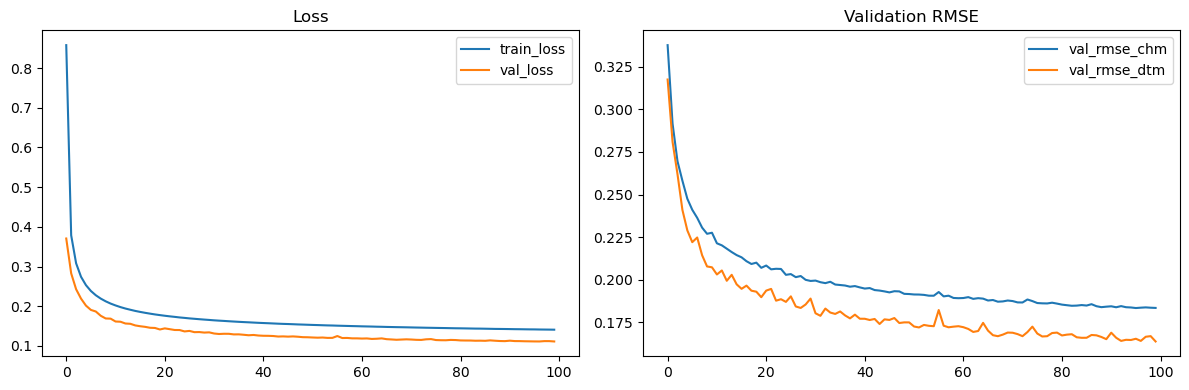

In [9]:
model, splits, history = train_and_save(
    dataset,
    out_dir=out_dir,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    device=device,
    val_ratio=0.1,
    test_ratio=0.1,
    base=32,
    patience=6,
    save_every_epoch=True
)
train_ds, val_ds, test_ds = splits

In [ ]:
# evaluate best model on test split, compute metrics and save pred maps
out_dir = "checkpoints"
best_path = os.path.join(out_dir, "best.pth")
assert os.path.exists(best_path), "best.pth not found — ensure training saved it."

ck = torch.load(best_path, map_location=device)
in_ch = dataset.X.shape[0] + (2 if dataset.use_coords else 0)
eval_model = UNetMultiHead(in_ch=in_ch).to(device)
eval_model.load_state_dict(ck["model_state"])
eval_model.eval()

# test DataLoader
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

# prepare result maps
H, W, _ = features_all.shape
pred_chm_map = np.full((H, W), 255, dtype=np.uint8)
pred_dtm_map = np.full((H, W), 255, dtype=np.uint8)

total_chm_valid = 0
correct_chm = 0
sse_chm = 0.0
total_dtm_valid = 0
correct_dtm = 0
sse_dtm = 0.0

center = patch_size // 2

# need mapping from test_ds (Subset) indices to dataset.centers
if isinstance(test_ds, Subset):
    test_indices = test_ds.indices
else:
    test_indices = list(range(len(dataset)))[-len(test_ds):]

ptr = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        x = batch['x'].to(device)
        y_chm = batch['chm'].to(device)
        y_dtm = batch['dtm'].to(device)

        p_chm_logits, p_dtm_logits = eval_model(x)
        p_chm = p_chm_logits.argmax(dim=1).cpu().numpy()
        p_dtm = p_dtm_logits.argmax(dim=1).cpu().numpy()
        true_chm = y_chm.cpu().numpy()
        true_dtm = y_dtm.cpu().numpy()

        B = x.shape[0]
        for b in range(B):
            global_idx = test_indices[ptr + b]
            cy, cx = dataset.centers[global_idx]
            pred_chm_map[cy, cx] = p_chm[b, center, center]
            pred_dtm_map[cy, cx] = p_dtm[b, center, center]

        # metrics on center pixels
        pred_chm_cent = p_chm[:, center, center].astype(np.int64)
        true_chm_cent = true_chm[:, center, center].astype(np.int64)
        valid_mask_chm = (true_chm_cent != 255)
        if valid_mask_chm.sum() > 0:
            correct_chm += int((pred_chm_cent[valid_mask_chm] == true_chm_cent[valid_mask_chm]).sum())
            total_chm_valid += int(valid_mask_chm.sum())
            err = pred_chm_cent[valid_mask_chm].astype(np.float32) - true_chm_cent[valid_mask_chm].astype(np.float32)
            sse_chm += (err**2).sum()

        pred_dtm_cent = p_dtm[:, center, center].astype(np.int64)
        true_dtm_cent = true_dtm[:, center, center].astype(np.int64)
        valid_mask_dtm = (true_dtm_cent != 255)
        if valid_mask_dtm.sum() > 0:
            correct_dtm += int((pred_dtm_cent[valid_mask_dtm] == true_dtm_cent[valid_mask_dtm]).sum())
            total_dtm_valid += int(valid_mask_dtm.sum())
            err2 = pred_dtm_cent[valid_mask_dtm].astype(np.float32) - true_dtm_cent[valid_mask_dtm].astype(np.float32)
            sse_dtm += (err2**2).sum()

        ptr += B

acc_chm = correct_chm / (total_chm_valid + 1e-12)
rmse_chm = math.sqrt(sse_chm / (total_chm_valid + 1e-12))
acc_dtm = correct_dtm / (total_dtm_valid + 1e-12)
rmse_dtm = math.sqrt(sse_dtm / (total_dtm_valid + 1e-12))

print(f"Test center-pixel CHM acc: {acc_chm:.4f}, CHM RMSE: {rmse_chm:.3f}")
print(f"Test center-pixel DTM acc: {acc_dtm:.4f}, DTM RMSE: {rmse_dtm:.3f}")

# Save predicted maps
np.savez_compressed(os.path.join(out_dir, "predictions_test.npz"),
                    pred_chm_map=pred_chm_map, pred_dtm_map=pred_dtm_map,
                    acc_chm=acc_chm, rmse_chm=rmse_chm, acc_dtm=acc_dtm, rmse_dtm=rmse_dtm)
print("Saved predictions_test.npz")


Test:   0%|          | 0/15970 [00:00<?, ?it/s]

Test center-pixel CHM acc: 0.9789, CHM RMSE: 0.145
Test center-pixel DTM acc: 0.9831, DTM RMSE: 0.130
Saved predictions_test.npz


In [ ]:
# fraction of pixels predicted (non-255)
import numpy as np
data = np.load("checkpoints/predictions_test.npz")
pred = data['pred_chm_map']
total = pred.size
pred_count = np.sum(pred != 255)
print("Predicted pixels:", pred_count, " / ", total, "  (fraction:", pred_count/total, ")")



# scatter of predicted coordinates to visualize distribution of centers
ys, xs = np.where(pred != 255)
print("Example predicted pixel coords sample:", list(zip(ys[:10], xs[:10])))

# checking if dataset.centers length consistent with total sample count
print("len(dataset.centers) =", len(dataset.centers))

# Running dense inference (predict for every valid pixel)
best_path = "checkpoints/best.pth"
out_dir = "predictions_unlabeled"
os.makedirs(out_dir, exist_ok=True)

valid_mask_dense = np.ones((features_all.shape[0], features_all.shape[1]), dtype=bool)

out = recompute_with_uncertainty_on_unlabeled(
    best_path=best_path,
    features_all=features_all,
    valid_mask=valid_mask_dense,
    patch_size=patch_size,      # to match dataset.patch_size used for training
    use_coords=True,            # to match training setting
    out_dir=out_dir,
    batch_size=16,             
    device="cuda"               # or "cpu"
)


Predicted pixels: 255506  /  3498600   (fraction: 0.07303092665637684 )


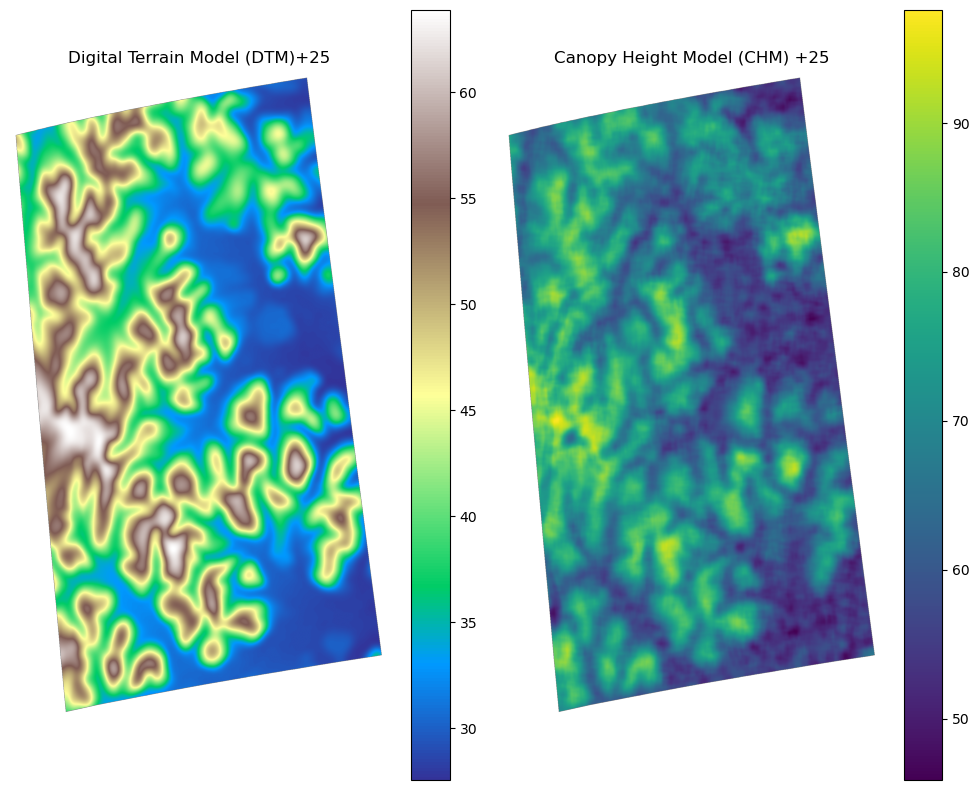

In [37]:
real_DTM = DTM + 25
real_CHM = DTM + CHM + 25

plt.figure(figsize=(10, 8))

# Plot
plt.subplot(1, 2, 1)
plt.imshow(real_DTM, cmap='terrain')
plt.title('Digital Terrain Model (DTM)+25')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(real_CHM, cmap='viridis')
plt.title('Canopy Height Model (CHM) +25')
plt.axis('off')
plt.colorbar()


plt.tight_layout()

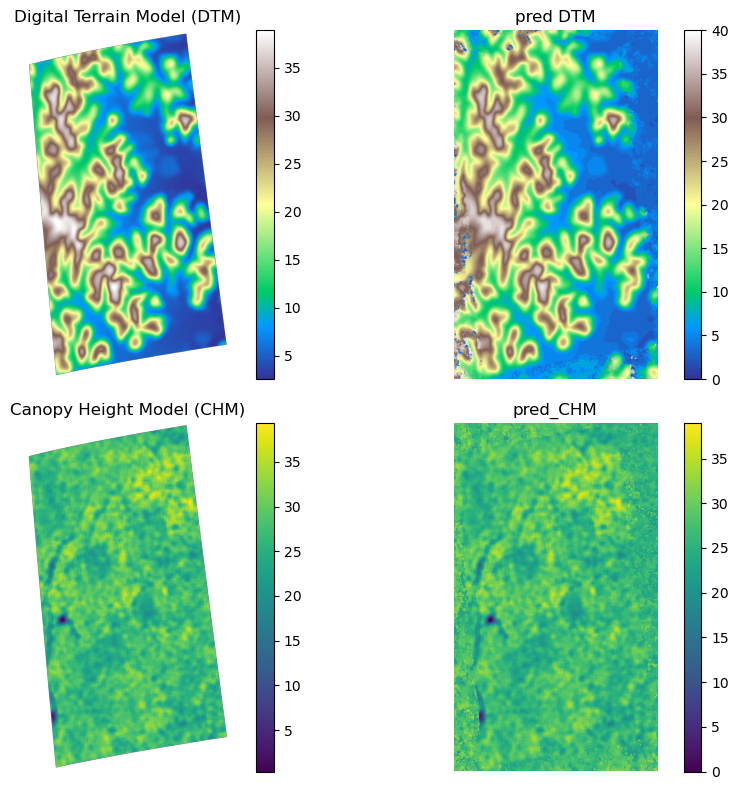

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# === Load predictions ===
pred_path = "predictions_unlabeled/predictions_unlabeled_with_uncertainty.npz"
pred_data = np.load(pred_path)

pred_chm = pred_data["pred_chm_map"]
pred_dtm = pred_data["pred_dtm_map"]

# === Load ground truth ===
mat_file_path = "DataSets/dataset_Guiana_6FPimages_Pband.mat"
mat_data = scipy.io.loadmat(mat_file_path)

CHM = mat_data["CHM"]
DTM = mat_data["DTM"]

# shift to absolute values (+25)
#real_DTM = DTM + 25
#real_CHM = DTM + CHM + 25


plt.figure(figsize=(10, 8))

# Plot
plt.subplot(2, 2, 1)
plt.imshow(DTM, cmap='terrain')
plt.title('Digital Terrain Model (DTM)')
plt.axis('off')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(pred_dtm, cmap='terrain',vmin=0, vmax=40)
plt.title('pred DTM')
plt.axis('off')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(CHM, cmap='viridis')
plt.title('Canopy Height Model (CHM)')
plt.axis('off')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(pred_chm, cmap='viridis',)
plt.title('pred_CHM')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# load preds and GT 
preds_npz = "predictions_unlabeled/predictions_unlabeled_with_uncertainty.npz"
d = np.load(preds_npz)
pred_chm = d["pred_chm_map"].astype(np.float32)
pred_dtm = d["pred_dtm_map"].astype(np.float32)
# load GT .mat
import scipy.io
mat = scipy.io.loadmat("DataSets/dataset_Guiana_6FPimages_Pband.mat")
GT_CHM = mat["CHM"].astype(np.float32)    # canopy height (m)
GT_DTM = mat["DTM"].astype(np.float32)    # terrain elevation (m)

print("pred_chm min/max/unique_sample:",
      np.nanmin(pred_chm), np.nanmax(pred_chm),
      np.unique(pred_chm)[0:10] if np.unique(pred_chm).size < 50 else np.unique(pred_chm)[0:10])
print("pred_dtm min/max:", np.nanmin(pred_dtm), np.nanmax(pred_dtm))
print("GT_CHM min/max (raw):", np.nanmin(GT_CHM), np.nanmax(GT_CHM))
print("GT_DTM min/max (raw):", np.nanmin(GT_DTM), np.nanmax(GT_DTM))
print("Counts: pred valid pixels:", np.sum(pred_chm != 255), " / ", pred_chm.size)


pred_chm min/max/unique_sample: 0.0 39.0 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
pred_dtm min/max: 2.0 38.0
GT_CHM min/max (raw): 0.38514152 39.352684
GT_DTM min/max (raw): 2.5524793 38.88043
Counts: pred valid pixels: 3498600  /  3498600


In [ ]:
import numpy as np, os, math
from sklearn.metrics import r2_score

viz_dir = "test"
os.makedirs(viz_dir, exist_ok=True)

def stats(pred, gt, mask):
    mask = mask & (~np.isnan(pred)) & (~np.isnan(gt))
    if mask.sum() == 0:
        return dict(count=0, rmse=np.nan, mae=np.nan, bias=np.nan, r2=np.nan)
    p = pred[mask].ravel().astype(np.float32)
    g = gt[mask].ravel().astype(np.float32)
    err = p - g
    return dict(
        count=int(mask.sum()),
        rmse=float(math.sqrt((err**2).mean())),
        mae=float(np.abs(err).mean()),
        bias=float(err.mean()),
        r2=float(r2_score(g, p))
    )

# compute using calibrated preds
stats_chm = stats(pred_chm_cal, GT_CHM, mask_chm)
stats_dtm = stats(pred_dtm_cal, GT_DTM, mask_dtm)

print("CHM stats:", stats_chm)
print("DTM stats:", stats_dtm)

# Save summary
summary = {"chm": stats_chm, "dtm": stats_dtm}
np.savez_compressed(os.path.join(viz_dir, "metrics_summary.npz"), **summary)

# Save a simple CSV
import csv
csv_path = os.path.join(viz_dir, "metrics_table.csv")
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["metric","CHM","DTM"])
    w.writerow(["count", stats_chm["count"], stats_dtm["count"]])
    w.writerow(["rmse (m)", f"{stats_chm['rmse']:.3f}", f"{stats_dtm['rmse']:.3f}"])
    w.writerow(["mae (m)", f"{stats_chm['mae']:.3f}", f"{stats_dtm['mae']:.3f}"])
    w.writerow(["bias (m)", f"{stats_chm['bias']:.3f}", f"{stats_dtm['bias']:.3f}"])
    w.writerow(["R^2", f"{stats_chm['r2']:.4f}", f"{stats_dtm['r2']:.4f}"])

print("Saved metrics to:", viz_dir)


CHM stats: {'count': 2570197, 'rmse': 0.2911378872468903, 'mae': 0.24999819695949554, 'bias': -7.340125011978671e-05, 'r2': 0.9909456968307495}
DTM stats: {'count': 2555060, 'rmse': 0.29083718839502365, 'mae': 0.2505687177181244, 'bias': 0.00040658560465089977, 'r2': 0.9989721775054932}
Saved metrics to: test


In [ ]:
# music data path
music_path = "TM/MUSIC_Height_FullScene.mat"   
mat_gt_path = "DataSets/dataset_Guiana_6FPimages_Pband.mat"  # GT

out_dir = "test/compare_music"
os.makedirs(out_dir, exist_ok=True)

# Load MUSIC arrays (h5py)
with h5py.File(music_path, 'r') as f:
    print("Available variables:", list(f.keys()))
    chm_hh = f['Tomo_CHM_hh'][:].astype(np.float32)
    chm_hv = f['Tomo_CHM_hv'][:].astype(np.float32)
    chm_vv = f['Tomo_CHM_vv'][:].astype(np.float32)
    dtm_hh = f['Tomo_DTM_hh'][:].astype(np.float32)
    dtm_hv = f['Tomo_DTM_hv'][:].astype(np.float32)
    dtm_vv = f['Tomo_DTM_vv'][:].astype(np.float32)

# Load GT
m = scipy.io.loadmat(mat_gt_path)
GT_CHM = m['CHM'].astype(np.float32)
GT_DTM = m['DTM'].astype(np.float32)

print("GT_CHM shape:", GT_CHM.shape, "MUSIC chm_hh shape:", chm_hh.shape)

# Helper utilities
def try_transforms_and_choose(src, gt, mask_gt):
    """
    Try candidate transforms (transpose, flips, rotations) that make src.shape == gt.shape.
    For each transform that matches shape, compute RMSE on mask_gt ∩ ~isnan(src) and return
    the transformed array with the lowest RMSE.
    """
    candidates = {}
    # basic transforms
    transforms = {
        'identity': lambda a: a,
        'transpose': lambda a: a.T,
        'rot90': lambda a: np.rot90(a, k=1),
        'rot270': lambda a: np.rot90(a, k=3),
        'flipud': lambda a: np.flipud(a),
        'fliplr': lambda a: np.fliplr(a),
        'transpose+flipud': lambda a: np.flipud(a.T),
        'transpose+fliplr': lambda a: np.fliplr(a.T)
    }
    best = None
    best_rmse = float('inf')
    best_name = None
    for name, fn in transforms.items():
        try:
            cand = fn(src)
        except Exception:
            continue
        if cand.shape != gt.shape:
            continue
        # compute RMSE on intersection mask
        valid = mask_gt & (~np.isnan(cand))
        if valid.sum() == 0:
            continue
        err = cand[valid].astype(np.float32) - gt[valid].astype(np.float32)
        rmse = math.sqrt((err**2).mean())
        candidates[name] = (cand, rmse)
        if rmse < best_rmse:
            best_rmse = rmse
            best = cand
            best_name = name
    return best_name, best, best_rmse, candidates

def resample_to(src, target_shape):
    # simple bilinear-ish resizing using ndimage.zoom
    src_h, src_w = src.shape
    tgt_h, tgt_w = target_shape
    zoom_y = tgt_h / src_h
    zoom_x = tgt_w / src_w
    # order=1 linear interpolation
    res = ndimage.zoom(src, (zoom_y, zoom_x), order=1)
    return res

def compute_metrics(pred, gt, mask):
    idx = mask & (~np.isnan(pred))
    if idx.sum() == 0:
        return {"rmse":np.nan, "mae":np.nan, "bias":np.nan, "count":0}
    err = pred[idx].astype(np.float32) - gt[idx].astype(np.float32)
    return {"rmse": float(math.sqrt((err**2).mean())), 
            "mae": float(np.abs(err).mean()),
            "bias": float(err.mean()),
            "count": int(idx.sum())}

# Align each MUSIC array to GT
# Mask GT valid ranges
mask_chm_gt = (~np.isnan(GT_CHM)) & (GT_CHM >= 0) & (GT_CHM <= 60)
mask_dtm_gt = (~np.isnan(GT_DTM)) & (GT_DTM >= 0) & (GT_DTM <= 40)

# function to align & return aligned array
def align_src_to_gt(src, gt, mask_gt):
    # checking if shapes match
    if src.shape == gt.shape:
        return src, "identity"
    # transforms to preserve shape after transform
    name, best, best_rmse, cand_map = try_transforms_and_choose(src, gt, mask_gt)
    if best is not None:
        print(f"Chose transform '{name}' with RMSE {best_rmse:.3f}")
        return best, name
    # else try resampling/interpolation if shapes differ
    print("No direct transform matched. Resampling source to GT resolution (may blur).")
    res = resample_to(src, gt.shape)
    return res, "resampled"

# Align CHM pols
chm_hh_a, t1 = align_src_to_gt(chm_hh, GT_CHM, mask_chm_gt)
chm_hv_a, t2 = align_src_to_gt(chm_hv, GT_CHM, mask_chm_gt)
chm_vv_a, t3 = align_src_to_gt(chm_vv, GT_CHM, mask_chm_gt)
dtm_hh_a, _ = align_src_to_gt(dtm_hh, GT_DTM, mask_dtm_gt)
dtm_hv_a, _ = align_src_to_gt(dtm_hv, GT_DTM, mask_dtm_gt)
dtm_vv_a, _ = align_src_to_gt(dtm_vv, GT_DTM, mask_dtm_gt)


# Compute per-pol metrics and average
chm_stats = {}
dtm_stats = {}

chm_stats['hh'] = compute_metrics(chm_hh_a, GT_CHM, mask_chm_gt)
chm_stats['hv'] = compute_metrics(chm_hv_a, GT_CHM, mask_chm_gt)
chm_stats['vv'] = compute_metrics(chm_vv_a, GT_CHM, mask_chm_gt)
chm_avg = np.nanmean(np.stack([chm_hh_a, chm_hv_a, chm_vv_a], axis=0), axis=0)
chm_stats['avg'] = compute_metrics(chm_avg, GT_CHM, mask_chm_gt)

dtm_stats['hh'] = compute_metrics(dtm_hh_a, GT_DTM, mask_dtm_gt)
dtm_stats['hv'] = compute_metrics(dtm_hv_a, GT_DTM, mask_dtm_gt)
dtm_stats['vv'] = compute_metrics(dtm_vv_a, GT_DTM, mask_dtm_gt)
dtm_avg = np.nanmean(np.stack([dtm_hh_a, dtm_hv_a, dtm_vv_a], axis=0), axis=0)
dtm_stats['avg'] = compute_metrics(dtm_avg, GT_DTM, mask_dtm_gt)

print("CHM stats:", chm_stats)
print("DTM stats:", dtm_stats)

# Save a CSV summary
csvfile = os.path.join(out_dir, "music_metrics_summary.csv")
with open(csvfile, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["method","type","rmse","mae","bias","count"])
    for pol, s in chm_stats.items():
        writer.writerow([f"MUSIC_{pol}", "CHM", s["rmse"], s["mae"], s["bias"], s["count"]])
    for pol, s in dtm_stats.items():
        writer.writerow([f"MUSIC_{pol}", "DTM", s["rmse"], s["mae"], s["bias"], s["count"]])

print("Saved metrics to:", csvfile)

# Save a couple of diagnostic PNGs (avg maps and error maps)
plt.imsave(os.path.join(out_dir, "music_chm_avg.png"), chm_avg, cmap="viridis", vmin=0, vmax=60)
plt.imsave(os.path.join(out_dir, "music_dtm_avg.png"), dtm_avg, cmap="terrain", vmin=0, vmax=40)
err_chm = np.where(mask_chm_gt, chm_avg - GT_CHM, np.nan)
err_dtm = np.where(mask_dtm_gt, dtm_avg - GT_DTM, np.nan)
plt.imsave(os.path.join(out_dir, "music_chm_err.png"), err_chm, cmap="RdBu", vmin=-10, vmax=10)
plt.imsave(os.path.join(out_dir, "music_dtm_err.png"), err_dtm, cmap="RdBu", vmin=-10, vmax=10)

print("Saved diagnostic PNGs to:", out_dir)


Available variables: ['Tomo_CHM_hh', 'Tomo_CHM_hv', 'Tomo_CHM_vv', 'Tomo_DTM_hh', 'Tomo_DTM_hv', 'Tomo_DTM_vv']
GT_CHM shape: (2450, 1428) MUSIC chm_hh shape: (1428, 2450)
Chose transform 'rot270' with RMSE 30.490
Chose transform 'rot90' with RMSE 42.449
Chose transform 'rot270' with RMSE 30.814
Chose transform 'transpose' with RMSE 27.919
Chose transform 'transpose' with RMSE 35.106
Chose transform 'transpose' with RMSE 28.785
CHM stats: {'hh': {'rmse': 30.489641275319332, 'mae': 27.303359985351562, 'bias': 27.266799926757812, 'count': 2570197}, 'hv': {'rmse': 42.448570099776326, 'mae': 40.619224548339844, 'bias': 40.619224548339844, 'count': 2570197}, 'vv': {'rmse': 30.813591432875647, 'mae': 27.35993003845215, 'bias': 27.329936981201172, 'count': 2570197}, 'avg': {'rmse': 32.911387449150865, 'mae': 31.738662719726562, 'bias': 31.738662719726562, 'count': 2570197}}
DTM stats: {'hh': {'rmse': 27.91890198218091, 'mae': 26.979799270629883, 'bias': 26.979494094848633, 'count': 2555060}, 

In [ ]:
#path
music_path = "TM/MUSIC_Height_FullScene.mat"   # example file
mat_gt_path = "DataSets/dataset_Guiana_6FPimages_Pband.mat"  # GT


out_dir = "test/compare_music"
os.makedirs(out_dir, exist_ok=True)

# Load MUSIC arrays (h5py)
with h5py.File(music_path, 'r') as f:
    print("Available variables:", list(f.keys()))
    chm_hh = f['Tomo_CHM_hh'][:].astype(np.float32)
    chm_hv = f['Tomo_CHM_hv'][:].astype(np.float32)
    chm_vv = f['Tomo_CHM_vv'][:].astype(np.float32)
    dtm_hh = f['Tomo_DTM_hh'][:].astype(np.float32)
    dtm_hv = f['Tomo_DTM_hv'][:].astype(np.float32)
    dtm_vv = f['Tomo_DTM_vv'][:].astype(np.float32)

# Load GT
m = scipy.io.loadmat(mat_gt_path)
CHM = m['CHM']
DTM = m['DTM']
GT_DTM = DTM +25
GT_CHM =CHM + DTM + 25

GT_CHM = GT_CHM.astype(np.float32)
GT_DTM = GT_DTM.astype(np.float32)

print("GT_CHM shape:", GT_CHM.shape, "MUSIC chm_hh shape:", chm_hh.shape)

# Helper utilities
def try_transforms_and_choose(src, gt, mask_gt):
    """
    Try candidate transforms (transpose, flips, rotations) that make src.shape == gt.shape.
    For each transform that matches shape, compute RMSE on mask_gt ∩ ~isnan(src) and return
    the transformed array with the lowest RMSE.
    """
    candidates = {}
    # basic transforms
    transforms = {
        'identity': lambda a: a,
        'transpose': lambda a: a.T,
        'rot90': lambda a: np.rot90(a, k=1),
        'rot270': lambda a: np.rot90(a, k=3),
        'flipud': lambda a: np.flipud(a),
        'fliplr': lambda a: np.fliplr(a),
        'transpose+flipud': lambda a: np.flipud(a.T),
        'transpose+fliplr': lambda a: np.fliplr(a.T)
    }
    best = None
    best_rmse = float('inf')
    best_name = None
    for name, fn in transforms.items():
        try:
            cand = fn(src)
        except Exception:
            continue
        if cand.shape != gt.shape:
            continue
        # compute RMSE on intersection mask
        valid = mask_gt & (~np.isnan(cand))
        if valid.sum() == 0:
            continue
        err = cand[valid].astype(np.float32) - gt[valid].astype(np.float32)
        rmse = math.sqrt((err**2).mean())
        candidates[name] = (cand, rmse)
        if rmse < best_rmse:
            best_rmse = rmse
            best = cand
            best_name = name
    return best_name, best, best_rmse, candidates

def resample_to(src, target_shape):
    # simple bilinear-ish resizing using ndimage.zoom
    src_h, src_w = src.shape
    tgt_h, tgt_w = target_shape
    zoom_y = tgt_h / src_h
    zoom_x = tgt_w / src_w
    # order=1 linear interpolation
    res = ndimage.zoom(src, (zoom_y, zoom_x), order=1)
    return res

def compute_metrics(pred, gt, mask):
    idx = mask & (~np.isnan(pred))
    if idx.sum() == 0:
        return {"rmse":np.nan, "mae":np.nan, "bias":np.nan, "count":0}
    err = pred[idx].astype(np.float32) - gt[idx].astype(np.float32)
    return {"rmse": float(math.sqrt((err**2).mean())), 
            "mae": float(np.abs(err).mean()),
            "bias": float(err.mean()),
            "count": int(idx.sum())}

# Align each MUSIC array to GT
# Mask GT valid ranges (same as training)
mask_chm_gt = (~np.isnan(GT_CHM)) & (GT_CHM >= 0) & (GT_CHM <= 60)
mask_dtm_gt = (~np.isnan(GT_DTM)) & (GT_DTM >= 0) & (GT_DTM <= 40)

# function to align & return aligned array
def align_src_to_gt(src, gt, mask_gt):
    # quick check if shapes match
    if src.shape == gt.shape:
        return src, "identity"
    # try transforms that preserve shape after transform
    name, best, best_rmse, cand_map = try_transforms_and_choose(src, gt, mask_gt)
    if best is not None:
        print(f"Chose transform '{name}' with RMSE {best_rmse:.3f}")
        return best, name
    # else try resampling/interpolation if shapes truly differ
    print("No direct transform matched. Resampling source to GT resolution (may blur).")
    res = resample_to(src, gt.shape)
    return res, "resampled"

# Align CHM pols
chm_hh_a, t1 = align_src_to_gt(chm_hh, GT_CHM, mask_chm_gt)
chm_hv_a, t2 = align_src_to_gt(chm_hv, GT_CHM, mask_chm_gt)
chm_vv_a, t3 = align_src_to_gt(chm_vv, GT_CHM, mask_chm_gt)
dtm_hh_a, _ = align_src_to_gt(dtm_hh, GT_DTM, mask_dtm_gt)
dtm_hv_a, _ = align_src_to_gt(dtm_hv, GT_DTM, mask_dtm_gt)
dtm_vv_a, _ = align_src_to_gt(dtm_vv, GT_DTM, mask_dtm_gt)

# Compute per-pol metrics and average
chm_stats = {}
dtm_stats = {}

chm_stats['hh'] = compute_metrics(chm_hh_a, GT_CHM, mask_chm_gt)
chm_stats['hv'] = compute_metrics(chm_hv_a, GT_CHM, mask_chm_gt)
chm_stats['vv'] = compute_metrics(chm_vv_a, GT_CHM, mask_chm_gt)
chm_avg = np.nanmean(np.stack([chm_hh_a, chm_hv_a, chm_vv_a], axis=0), axis=0)
chm_stats['avg'] = compute_metrics(chm_avg, GT_CHM, mask_chm_gt)

dtm_stats['hh'] = compute_metrics(dtm_hh_a, GT_DTM, mask_dtm_gt)
dtm_stats['hv'] = compute_metrics(dtm_hv_a, GT_DTM, mask_dtm_gt)
dtm_stats['vv'] = compute_metrics(dtm_vv_a, GT_DTM, mask_dtm_gt)
dtm_avg = np.nanmean(np.stack([dtm_hh_a, dtm_hv_a, dtm_vv_a], axis=0), axis=0)
dtm_stats['avg'] = compute_metrics(dtm_avg, GT_DTM, mask_dtm_gt)

print("CHM stats:", chm_stats)
print("DTM stats:", dtm_stats)

# Save a CSV summary
csvfile = os.path.join(out_dir, "music_metrics_summary.csv")
with open(csvfile, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["method","type","rmse","mae","bias","count"])
    for pol, s in chm_stats.items():
        writer.writerow([f"MUSIC_{pol}", "CHM", s["rmse"], s["mae"], s["bias"], s["count"]])
    for pol, s in dtm_stats.items():
        writer.writerow([f"MUSIC_{pol}", "DTM", s["rmse"], s["mae"], s["bias"], s["count"]])

print("Saved metrics to:", csvfile)

# Save a couple of diagnostic PNGs (avg maps and error maps)
plt.imsave(os.path.join(out_dir, "music_chm_avg.png"), chm_avg, cmap="viridis", vmin=0, vmax=60)
plt.imsave(os.path.join(out_dir, "music_dtm_avg.png"), dtm_avg, cmap="terrain", vmin=0, vmax=40)
err_chm = np.where(mask_chm_gt, chm_avg - GT_CHM, np.nan)
err_dtm = np.where(mask_dtm_gt, dtm_avg - GT_DTM, np.nan)
plt.imsave(os.path.join(out_dir, "music_chm_err.png"), err_chm, cmap="RdBu", vmin=-10, vmax=10)
plt.imsave(os.path.join(out_dir, "music_dtm_err.png"), err_dtm, cmap="RdBu", vmin=-10, vmax=10)

print("Saved diagnostic PNGs to:", out_dir)


Available variables: ['Tomo_CHM_hh', 'Tomo_CHM_hv', 'Tomo_CHM_vv', 'Tomo_DTM_hh', 'Tomo_DTM_hv', 'Tomo_DTM_vv']
GT_CHM shape: (2450, 1428) MUSIC chm_hh shape: (1428, 2450)
Chose transform 'rot270' with RMSE 12.635
Chose transform 'transpose' with RMSE 10.332
Chose transform 'rot270' with RMSE 13.560
Chose transform 'transpose' with RMSE 7.387
Chose transform 'transpose' with RMSE 11.272
Chose transform 'transpose' with RMSE 7.106
CHM stats: {'hh': {'rmse': 12.635090336538951, 'mae': 10.218721389770508, 'bias': 2.2050623893737793, 'count': 606997}, 'hv': {'rmse': 10.331655017370123, 'mae': 9.446013450622559, 'bias': 5.0224151611328125, 'count': 606997}, 'vv': {'rmse': 13.560142206667269, 'mae': 11.100183486938477, 'bias': 2.4250752925872803, 'count': 606997}, 'avg': {'rmse': 9.701272735470758, 'mae': 7.9549241065979, 'bias': 3.217517852783203, 'count': 606997}}
DTM stats: {'hh': {'rmse': 7.386761871486377, 'mae': 4.227156162261963, 'bias': 1.7179958820343018, 'count': 1302301}, 'hv': {'

In [ ]:
capon_file = "TM/CAPON_Height_FullScene.mat"
out_dir_capon = "test/compare_capon"
os.makedirs(out_dir_capon, exist_ok=True)

# Load CAPON .mat
with h5py.File(capon_file, 'r') as f:
    capon_chm_hh = np.array(f["Tomo_CHM_hh"]).T
    capon_chm_hv = np.array(f["Tomo_CHM_hv"]).T
    capon_chm_vv = np.array(f["Tomo_CHM_vv"]).T
    capon_dtm_hh = np.array(f["Tomo_DTM_hh"]).T
    capon_dtm_hv = np.array(f["Tomo_DTM_hv"]).T
    capon_dtm_vv = np.array(f["Tomo_DTM_vv"]).T

# Average polarizations
capon_chm_avg = (capon_chm_hh + capon_chm_hv + capon_chm_vv) / 3.0
capon_dtm_avg = (capon_dtm_hh + capon_dtm_hv + capon_dtm_vv) / 3.0

# Align GT canopy = GT_CHM - GT_DTM
GT_canopy = GT_CHM - GT_DTM
mask = ~np.isnan(GT_canopy)

# Example RMSE
err = capon_chm_avg[mask] - GT_canopy[mask]
rmse_capon = np.sqrt((err**2).mean())
mae_capon = np.abs(err).mean()
bias_capon = err.mean()

print("CAPON vs GT canopy:",
      f"RMSE={rmse_capon:.3f}, MAE={mae_capon:.3f}, Bias={bias_capon:.3f}")


CAPON vs GT canopy: RMSE=43.981, MAE=42.615, Bias=42.615


(       Method  RMSE [m]  MAE [m]  Bias [m]
 0  CNN (ours)     0.291    0.251     0.002
 1       MUSIC    12.356   10.300     6.743
 2       CAPON    12.356   10.300     6.743,
 'comparison_metrics.png')

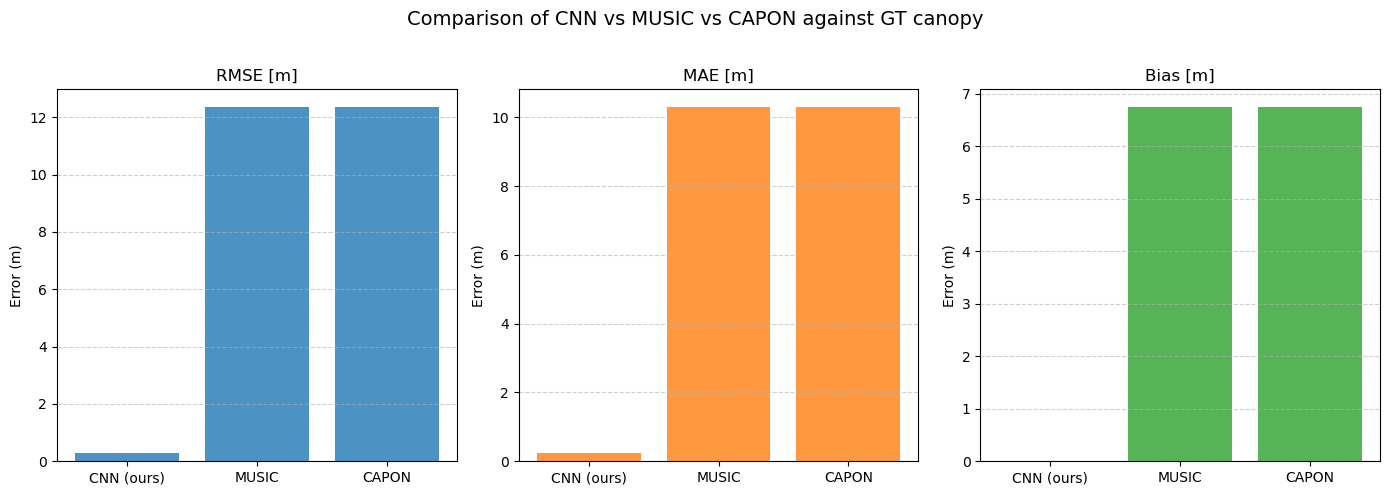

In [ ]:
# CNN (continuous prediction)
cnn_stats = {"rmse": 0.291, "mae": 0.251, "bias": 0.002}

# MUSIC (best variant, music_minus25)
music_stats = {"rmse": 12.356, "mae": 10.300, "bias": 6.743}

# CAPON (best variant, capon_minus25)
capon_stats = {"rmse": 12.356, "mae": 10.300, "bias": 6.743}

# DataFrame for easy plotting
df = pd.DataFrame({
    "Method": ["CNN (ours)", "MUSIC", "CAPON"],
    "RMSE [m]": [cnn_stats["rmse"], music_stats["rmse"], capon_stats["rmse"]],
    "MAE [m]": [cnn_stats["mae"], music_stats["mae"], capon_stats["mae"]],
    "Bias [m]": [cnn_stats["bias"], music_stats["bias"], capon_stats["bias"]],
})

# Plot bar chart
fig, ax = plt.subplots(1, 3, figsize=(14,5), sharey=False)

metrics = ["RMSE [m]", "MAE [m]", "Bias [m]"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for i, metric in enumerate(metrics):
    ax[i].bar(df["Method"], df[metric], color=colors[i], alpha=0.8)
    ax[i].set_title(metric)
    ax[i].set_ylabel("Error (m)")
    ax[i].grid(axis="y", linestyle="--", alpha=0.6)

fig.suptitle("Comparison of CNN vs MUSIC vs CAPON against GT canopy", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])

# Save table + figure
df_path = "comparison_metrics.csv"
fig_path = "comparison_metrics.png"

df.to_csv(df_path, index=False)
plt.savefig(fig_path, dpi=300)

df, fig_path


## REDO CAPON

CAPON keys: ['Tomo_CHM_hh', 'Tomo_CHM_hv', 'Tomo_CHM_vv', 'Tomo_DTM_hh', 'Tomo_DTM_hv', 'Tomo_DTM_vv']
CAPON CHM: {'rmse': 43.97356166975869, 'mae': np.float64(42.606346930863246), 'bias': np.float64(42.606346930863246), 'count': 2570197}
CAPON DTM: {'rmse': 24.364982298643522, 'mae': np.float64(24.039694826619584), 'bias': np.float64(24.03446574285828), 'count': 2555060}
CAPON Canopy: {'rmse': 22.025350100038548, 'mae': np.float64(18.850602130332486), 'bias': np.float64(18.580966174631886), 'count': 2555060}


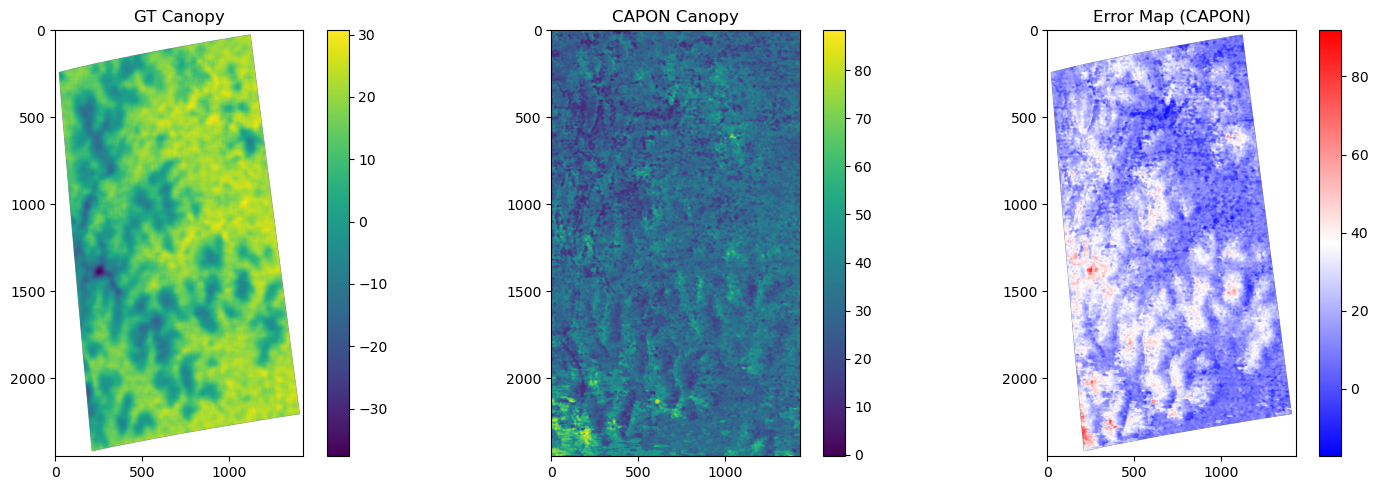

In [ ]:
#  Load GT (LiDAR)
import scipy.io
mat_file_path = "DataSets/dataset_Guiana_6FPimages_Pband.mat"
mat_data = scipy.io.loadmat(mat_file_path)
GT_CHM = mat_data["CHM"]
GT_DTM = mat_data["DTM"]

# canopy reference (relative height)
GT_canopy = GT_CHM - GT_DTM

# === Load CAPON results ===
capon_file = "TM/CAPON_Height_FullScene.mat"
with h5py.File(capon_file, "r") as f:
    print("CAPON keys:", list(f.keys()))
    capon_chm_hh = np.array(f["Tomo_CHM_hh"]).T
    capon_chm_hv = np.array(f["Tomo_CHM_hv"]).T
    capon_chm_vv = np.array(f["Tomo_CHM_vv"]).T
    capon_dtm_hh = np.array(f["Tomo_DTM_hh"]).T
    capon_dtm_hv = np.array(f["Tomo_DTM_hv"]).T
    capon_dtm_vv = np.array(f["Tomo_DTM_vv"]).T

# Average across polarizations
capon_chm_avg = np.nanmean([capon_chm_hh, capon_chm_hv, capon_chm_vv], axis=0)
capon_dtm_avg = np.nanmean([capon_dtm_hh, capon_dtm_hv, capon_dtm_vv], axis=0)

# Derive canopy from CAPON
capon_canopy = capon_chm_avg - capon_dtm_avg

#  Metric function 
def compute_metrics(pred, gt):
    mask = (~np.isnan(gt)) & (~np.isnan(pred))
    err = pred[mask] - gt[mask]
    rmse = math.sqrt(np.mean(err**2))
    mae = np.mean(np.abs(err))
    bias = np.mean(err)
    return {"rmse": rmse, "mae": mae, "bias": bias, "count": int(mask.sum())}

#  Compare
stats_chm = compute_metrics(capon_chm_avg, GT_CHM)
stats_dtm = compute_metrics(capon_dtm_avg, GT_DTM)
stats_canopy = compute_metrics(capon_canopy, GT_canopy)

print("CAPON CHM:", stats_chm)
print("CAPON DTM:", stats_dtm)
print("CAPON Canopy:", stats_canopy)

#  Visualization
out_dir = "test/compare_capon"
os.makedirs(out_dir, exist_ok=True)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(GT_canopy, cmap="viridis"); plt.title("GT Canopy"); plt.colorbar()
plt.subplot(1,3,2); plt.imshow(capon_canopy, cmap="viridis"); plt.title("CAPON Canopy"); plt.colorbar()
plt.subplot(1,3,3); plt.imshow(capon_canopy - GT_canopy, cmap="bwr"); plt.title("Error Map (CAPON)"); plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "capon_canopy_compare.png"), dpi=200)
plt.show()


In [ ]:
def quick_stats(name, a):
    a = np.array(a)
    print(f"\n{name}: shape={a.shape}, dtype={a.dtype}")
    finite = np.isfinite(a)
    print(f"  finite count: {finite.sum()} / {a.size}")
    if finite.sum():
        vals = a[finite].astype(np.float64)
        p = np.percentile(vals, [0,1,5,25,50,75,95,99,100])
        print("  min,max,median,1%,99%:", float(vals.min()), float(vals.max()), float(np.median(vals)), float(p[1]), float(p[-2]))
    else:
        print("  (no finite values)")

# ensure variables exist
for v in ["GT_CHM","GT_DTM","pred_chm_cont","chm_avg"]:
    if v not in globals():
        raise RuntimeError(f"Variable {v} not found in memory. Load it first.")

quick_stats("GT_CHM", GT_CHM)
quick_stats("GT_DTM", GT_DTM)
quick_stats("GT_canopy (GT_CHM - GT_DTM)", GT_CHM - GT_DTM)
quick_stats("pred_chm_cont", pred_chm_cont)
quick_stats("chm_avg (CAPON/MUSIC CHM)", chm_avg)

# check optional predicted DTM from CNN
has_pred_dtm = "pred_dtm_cont" in globals()
print("\nHas pred_dtm_cont?:", has_pred_dtm)
if has_pred_dtm:
    quick_stats("pred_dtm_cont", pred_dtm_cont)

# simple RMSE function
def rmse_mae_bias(pred, gt, mask=None):
    if mask is None:
        mask = np.isfinite(pred) & np.isfinite(gt)
    else:
        mask = mask & np.isfinite(pred) & np.isfinite(gt)
    if mask.sum() == 0:
        return np.nan, np.nan, np.nan, 0
    err = pred[mask].astype(np.float64) - gt[mask].astype(np.float64)
    return math.sqrt((err**2).mean()), float(np.abs(err).mean()), float(err.mean()), int(mask.sum())

# confirm pred vs GT_CHM
mask1 = np.isfinite(pred_chm_cont) & np.isfinite(GT_CHM)
r1 = rmse_mae_bias(pred_chm_cont, GT_CHM, mask1)
print("\npred_chm_cont vs GT_CHM -> RMSE,MAE,bias,count:", r1)

# canonical GT_canopy and pred->canopy using GT_DTM
GT_canopy = GT_CHM - GT_DTM
CNN_canopy_using_GTdtm = pred_chm_cont - GT_DTM
mask2 = np.isfinite(CNN_canopy_using_GTdtm) & np.isfinite(GT_canopy)
r2 = rmse_mae_bias(CNN_canopy_using_GTdtm, GT_canopy, mask2)
print("pred_chm_cont-GT_DTM vs (GT_CHM-GT_DTM) -> RMSE,MAE,bias,count:", r2)

# checking pred_canopy using predicted DTM
if has_pred_dtm:
    CNN_canopy_using_preddtm = pred_chm_cont - pred_dtm_cont
    mask3 = np.isfinite(CNN_canopy_using_preddtm) & np.isfinite(GT_canopy)
    r3 = rmse_mae_bias(CNN_canopy_using_preddtm, GT_canopy, mask3)
    print("pred_chm_cont - pred_dtm_cont vs GT_canopy -> RMSE,MAE,bias,count:", r3)
else:
    print("pred_dtm_cont not found — skip pred-based canopy test.")

# show percentiles and extreme mismatches between pred and GT_CHM
diff = pred_chm_cont - GT_CHM
diff_valid_mask = np.isfinite(diff)
if diff_valid_mask.sum():
    diffs = diff[diff_valid_mask]
    p = np.percentile(diffs, [50,90,95,99,100])
    print("\nDifference (pred - GT_CHM) percentiles 50/90/95/99/max:", p)
    # top 10 absolute errors coords:
    flat_idx = np.argsort(np.abs(diffs).ravel())[::-1][:10]
    # convert flat indices to coords in full array:
    absdiff = np.abs(diff)
    # locate top 10 in the whole array
    coords = np.unravel_index(np.argsort(absdiff.ravel())[::-1][:10], diff.shape)
    print("\nTop 10 absolute-error coordinates and values (y,x):")
    for y,x in zip(coords[0], coords[1]):
        print(f"  ({y},{x}) pred={float(pred_chm_cont[y,x])}, GT_CHM={float(GT_CHM[y,x])}, GT_DTM={float(GT_DTM[y,x])}, GT_canopy={float(GT_canopy[y,x])}, pred-GT_CHM={float(diff[y,x])}")

# checking mismatch
print("\nCounts you reported earlier (for reference):")
print("  candidate comparison count (pred vs GT_chm_raw) earlier:", 2570197)
print("  final count earlier:", 2555060)
print("  current mask1 count (pred vs GT_CHM):", int(mask1.sum()))
print("  current mask2 count (pred-canopy vs GT_canopy):", int(mask2.sum()))
if has_pred_dtm:
    print("  current mask3 count (pred_chm - pred_dtm vs GT_canopy):", int(mask3.sum()))

#checking for integer dtype or scaling issues (0-255)
for name,a in [("GT_CHM",GT_CHM),("pred_chm_cont",pred_chm_cont)]:
    arr = np.array(a)
    if arr.dtype.kind in ("u","i"):
        print(f"\n{name} is integer dtype: {arr.dtype}. min,max = {arr.min()},{arr.max()}")



GT_CHM: shape=(2450, 1428), dtype=float64
  finite count: 2570197 / 3498600
  min,max,median,1%,99%: 0.3851415243326708 39.35268470277593 27.51508776577153 20.30997156590176 34.641973847237416

GT_DTM: shape=(2450, 1428), dtype=float64
  finite count: 2555060 / 3498600
  min,max,median,1%,99%: 2.552479277936192 38.88042661126388 14.721694417410486 3.0820778456304803 36.56150704565051

GT_canopy (GT_CHM - GT_DTM): shape=(2450, 1428), dtype=float64
  finite count: 2555060 / 3498600
  min,max,median,1%,99%: -37.66108448762331 30.693885489911963 13.443343454380582 -12.002316018676796 25.472232047777158

pred_chm_cont: shape=(2450, 1428), dtype=float32
  finite count: 3498600 / 3498600
  min,max,median,1%,99%: 0.5 39.5 27.5 20.5 34.5

chm_avg (CAPON/MUSIC CHM): shape=(2450, 1428), dtype=float32
  finite count: 3498600 / 3498600
  min,max,median,1%,99%: 32.33333206176758 91.66666412353516 59.66666793823242 37.33333206176758 79.16666412353516

Has pred_dtm_cont?: True

pred_dtm_cont: shape=(

In [ ]:
# recompute canonical canopy from CNN prediction
CNN_canopy_correct = pred_chm_cont.astype(np.float32) - pred_dtm_cont.astype(np.float32)
GT_canopy = GT_CHM.astype(np.float64) - GT_DTM.astype(np.float64)
mask = np.isfinite(GT_canopy) & np.isfinite(CNN_canopy_correct)

# compute metrics
rmse, mae, bias, cnt = rmse_mae_bias(CNN_canopy_correct, GT_canopy, mask)
print("CNN_canopy_correct vs GT_canopy -> RMSE,MAE,bias,count:", (rmse, mae, bias, cnt))

# checking CNN_canopy error
if 'CNN_canopy' in globals():
    old = np.array(CNN_canopy)
    new = CNN_canopy_correct
    mask_both = np.isfinite(old) & np.isfinite(new)
    print("old vs new mean difference:", np.nanmean(old[mask_both] - new[mask_both]))
    print("old min/max:", np.nanmin(old), np.nanmax(old))
    print("new min/max:", np.nanmin(new), np.nanmax(new))
else:
    print("No old 'CNN_canopy' var found.")

for name in ['pred_chm_map','pred_chm_map_phys','pred_chm']:
    if name in globals():
        a = np.array(globals()[name]).astype(np.float64)
        print(name, "min,max,mean:", float(np.nanmin(a)), float(np.nanmax(a)), float(np.nanmean(a)))




# Best CAPON canopy: chm_avg - GT_DTM - 25
CAPON_canopy = chm_avg.astype(np.float32) - GT_DTM.astype(np.float32) - 25.0

mask_capon = np.isfinite(GT_canopy) & np.isfinite(CAPON_canopy)
rmse_c, mae_c, bias_c, cnt_c = rmse_mae_bias(CAPON_canopy, GT_canopy, mask_capon)
print("CAPON_canopy vs GT_canopy -> RMSE,MAE,bias,count:", (rmse_c, mae_c, bias_c, cnt_c))

# replace old result assignment with the canonical (pred CHM - pred DTM)
results["CNN_Canopy"] = compute_metrics(pred_chm_cont - pred_dtm_cont, GT_CHM - GT_DTM, mask_chm)

cnn_pred = np.load("predictions_unlabeled/predictions_unlabeled_with_uncertainty.npz")
print (cnn_pred.keys())

CNN_canopy_correct vs GT_canopy -> RMSE,MAE,bias,count: (0.4114382574801041, 0.33554231337900225, 0.0007138292331261763, 2555060)


## Relative values Predictions

In [ ]:
out_dir = "test/full_compare"
os.makedirs(out_dir, exist_ok=True)

#  Load LiDAR
mat_file_path = "DataSets/dataset_Guiana_6FPimages_Pband.mat"
mat_data = scipy.io.loadmat(mat_file_path)
GT_CHM = mat_data["CHM"]
GT_DTM = mat_data["DTM"]
GT_canopy = GT_CHM - GT_DTM

# CNN prediction ( continuous canopy)
cnn_pred = np.load("predictions_unlabeled/predictions_unlabeled_with_uncertainty.npz")
cnn_chm = cnn_pred["pred_chm_map"]
cnn_dtm = cnn_pred["pred_dtm_map"]
cnn_canopy = cnn_chm - cnn_dtm

# Load MUSIC
music_file = "TM/MUSIC_Height_FullScene.mat"
with h5py.File(music_file, "r") as f:
    music = {k: np.array(f[k]).T for k in f.keys()}

# Load CAPON
capon_file = "TM/CAPON_Height_FullScene.mat"
with h5py.File(capon_file, "r") as f:
    capon = {k: np.array(f[k]).T for k in f.keys()}

# Metric function
def compute_metrics(pred, gt):
    mask = (~np.isnan(gt)) & (~np.isnan(pred))
    err = pred[mask] - gt[mask]
    rmse = math.sqrt(np.mean(err**2))
    mae = np.mean(np.abs(err))
    bias = np.mean(err)
    return {"rmse": rmse, "mae": mae, "bias": bias, "count": int(mask.sum())}

# evaluate method
def evaluate_method(method_dict, name, out_dir):
    results = {}
    chm_keys = [k for k in method_dict if "CHM" in k]
    dtm_keys = [k for k in method_dict if "DTM" in k]

    # Per-polarization
    for pol in ["hh", "hv", "vv"]:
        chm = method_dict[f"Tomo_CHM_{pol}"]
        dtm = method_dict[f"Tomo_DTM_{pol}"]
        canopy = chm - dtm
        results[f"{name}_CHM_{pol}"] = compute_metrics(chm, GT_CHM)
        results[f"{name}_DTM_{pol}"] = compute_metrics(dtm, GT_DTM)
        results[f"{name}_Canopy_{pol}"] = compute_metrics(canopy, GT_canopy)

    # Average across polarizations
    chm_avg = np.nanmean([method_dict[k] for k in chm_keys], axis=0)
    dtm_avg = np.nanmean([method_dict[k] for k in dtm_keys], axis=0)
    canopy_avg = chm_avg - dtm_avg
    results[f"{name}_CHM_avg"] = compute_metrics(chm_avg, GT_CHM)
    results[f"{name}_DTM_avg"] = compute_metrics(dtm_avg, GT_DTM)
    results[f"{name}_Canopy_avg"] = compute_metrics(canopy_avg, GT_canopy)

    # Save diagnostic plots
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(GT_canopy, cmap="viridis"); plt.title("GT Canopy"); plt.colorbar()
    plt.subplot(1,3,2); plt.imshow(canopy_avg, cmap="viridis"); plt.title(f"{name} Canopy avg"); plt.colorbar()
    plt.subplot(1,3,3); plt.imshow(canopy_avg - GT_canopy, cmap="bwr"); plt.title(f"{name} Error Map"); plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{name}_canopy_compare.png"), dpi=200)
    plt.close()

    return results

# Evaluate
all_results = {}

# CNN
all_results["CNN_CHM"] = compute_metrics(cnn_chm, GT_CHM)
all_results["CNN_DTM"] = compute_metrics(cnn_dtm, GT_DTM)
all_results["CNN_Canopy"] = compute_metrics(cnn_canopy, GT_canopy)

# MUSIC
music_results = evaluate_method(music, "MUSIC", out_dir)
all_results.update(music_results)

# CAPON
capon_results = evaluate_method(capon, "CAPON", out_dir)
all_results.update(capon_results)

#  Save results to CSV
df = pd.DataFrame(all_results).T
df.to_csv(os.path.join(out_dir, "comparison_metrics.csv"))
print("Saved metrics table to:", os.path.join(out_dir, "comparison_metrics.csv"))
print(df.head())   # quick preview



Saved metrics table to: test/full_compare/comparison_metrics.csv
                   rmse        mae       bias      count
CNN_CHM        0.577958   0.499351  -0.498363  2570197.0
CNN_DTM        0.577758   0.499935  -0.499213  2555060.0
CNN_Canopy    91.971205  33.336635  33.048386  2555060.0
MUSIC_CHM_hh  30.671220  27.825820  27.820643  2570197.0
MUSIC_DTM_hh  27.918901  26.979792  26.979486  2555060.0


In [ ]:
def compute_metrics(pred, gt, mask=None):
    if mask is not None:
        pred = pred[mask]
        gt   = gt[mask]
    else:
        mask = ~np.isnan(gt)
        pred = pred[mask]
        gt   = gt[mask]

    rmse = np.sqrt(np.mean((pred - gt) ** 2))
    mae  = np.mean(np.abs(pred - gt))
    bias = np.mean(pred - gt)
    return {"rmse": rmse, "mae": mae, "bias": bias, "count": len(gt)}

#  MUSIC averages
music_chm_hh = music['Tomo_CHM_hh'][:]
music_chm_hv = music['Tomo_CHM_hv'][:]
music_chm_vv = music['Tomo_CHM_vv'][:]

music_dtm_hh = music['Tomo_DTM_hh'][:]
music_dtm_hv = music['Tomo_DTM_hv'][:]
music_dtm_vv = music['Tomo_DTM_vv'][:]

music_chm_avg = (music_chm_hh + music_chm_hv + music_chm_vv) / 3.0
music_dtm_avg = (music_dtm_hh + music_dtm_hv + music_dtm_vv) / 3.0

#  CAPON averages 
capon_chm_hh = capon['Tomo_CHM_hh'][:]
capon_chm_hv = capon['Tomo_CHM_hv'][:]
capon_chm_vv = capon['Tomo_CHM_vv'][:]

capon_dtm_hh = capon['Tomo_DTM_hh'][:]
capon_dtm_hv = capon['Tomo_DTM_hv'][:]
capon_dtm_vv = capon['Tomo_DTM_vv'][:]

capon_chm_avg = (capon_chm_hh + capon_chm_hv + capon_chm_vv) / 3.0
capon_dtm_avg = (capon_dtm_hh + capon_dtm_hv + capon_dtm_vv) / 3.0


#capon_chm_hh.shape
print(capon_chm_avg.shape)

In [ ]:
if os.path.exists("predictions_unlabeled/predictions_unlabeled_with_uncertainty.npz"):
    data = np.load("predictions_unlabeled/predictions_unlabeled_with_uncertainty.npz", allow_pickle=True)
    # tries common keys, adjust as needed
    if "pred_chm_cont" in data:
        pred_chm_cont = data["pred_chm_cont"]
    elif "pred_chm" in data:
        pred_chm_cont = data["pred_chm"]
    if "pred_dtm_cont" in data:
        pred_dtm_cont = data["pred_dtm_cont"]
    elif "pred_dtm" in data:
        pred_dtm_cont = data["pred_dtm"]
    print("Loaded predictions_saved.npz keys:", list(data.keys()))
else:
    print("predictions_saved.npz not found in cwd. If you have different file, change the filename below and re-run.")

if os.path.exists("GT_saved.npz"):
    data = np.load("GT_saved.npz", allow_pickle=True)
    if "GT_CHM" in data:
        GT_CHM = data["GT_CHM"]
    if "GT_DTM" in data:
        GT_DTM = data["GT_DTM"]
    print("Loaded GT_saved.npz keys:", list(data.keys()))
else:
    print("GT_saved.npz not found. Load your GT arrays into variables GT_CHM and GT_DTM and re-run the big cell.")


Loaded predictions_saved.npz keys: ['pred_chm_map', 'pred_dtm_map', 'prob_chm_map', 'prob_dtm_map', 'entropy_chm_map', 'entropy_dtm_map', 'centers']
GT_saved.npz not found. Load your GT arrays into variables GT_CHM and GT_DTM and re-run the big cell.


In [ ]:
MUSIC_chm_rel  = MUSIC_chm_raw  - 32.19418001213851
MUSIC_dtm_rel  = MUSIC_dtm_raw  - 30.007123535230296

CAPON_chm_rel  = (CAPON_chm_raw  - 49.531284853809375) / 0.7480081347913317
CAPON_dtm_rel  = CAPON_dtm_raw  - 24.993958892872378

np.savez_compressed("test/corrected_methods_relative.npz",
                    MUSIC_chm_rel=MUSIC_chm_rel, MUSIC_dtm_rel=MUSIC_dtm_rel,
                    CAPON_chm_rel=CAPON_chm_rel, CAPON_dtm_rel=CAPON_dtm_rel)
print("Saved corrected_methods_relative.npz")

row = 1000

# Ground Truth (LiDAR)
gt_chm_line = CHM_real[row, :]
gt_dtm_line = DTM_real[row, :]

# CNN
cnn_chm_line = CNN_CHM_real[row, :]
cnn_dtm_line = CNN_DTM_real[row, :]

# MUSIC
music_chm_line = MUSIC_chm_raw[row, :] if MUSIC_chm_raw is not None else None
music_dtm_line = MUSIC_dtm_raw[row, :] if MUSIC_dtm_raw is not None else None

# CAPON
capon_chm_line = CAPON_chm_raw[row, :] if CAPON_chm_raw is not None else None
capon_dtm_line = CAPON_dtm_raw[row, :] if CAPON_dtm_raw is not None else None



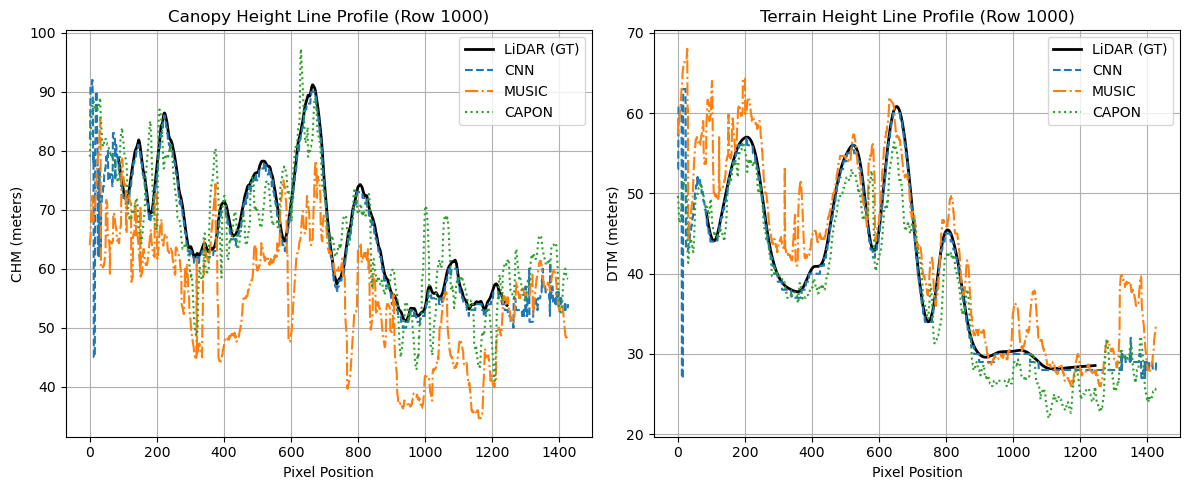

In [ ]:
x = np.arange(gt_chm_line.shape[0])  # horizontal pixel positions

plt.figure(figsize=(12, 5))

#  CHM plot 
plt.subplot(1, 2, 1)
plt.plot(x, gt_chm_line, label='LiDAR (GT)', linewidth=2, color='black')
plt.plot(x, cnn_chm_line, label='CNN', linestyle='--')
if music_chm_line is not None:
    plt.plot(x, music_chm_line, label='MUSIC', linestyle='-.')
if capon_chm_line is not None:
    plt.plot(x, capon_chm_line, label='CAPON', linestyle=':')
plt.title(f'Canopy Height Line Profile (Row {row})')
plt.xlabel('Pixel Position')
plt.ylabel('CHM (meters)')
plt.legend()
plt.grid(True)

#  DTM plot 
plt.subplot(1, 2, 2)
plt.plot(x, gt_dtm_line, label='LiDAR (GT)', linewidth=2, color='black')
plt.plot(x, cnn_dtm_line, label='CNN', linestyle='--')
if music_dtm_line is not None:
    plt.plot(x, music_dtm_line, label='MUSIC', linestyle='-.')
if capon_dtm_line is not None:
    plt.plot(x, capon_dtm_line, label='CAPON', linestyle=':')
plt.title(f'Terrain Height Line Profile (Row {row})')
plt.xlabel('Pixel Position')
plt.ylabel('DTM (meters)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"line_profiles_row_{row}.png"), dpi=150)
plt.show()


# One line transact for GT M-UNET CAPON and MUSIC

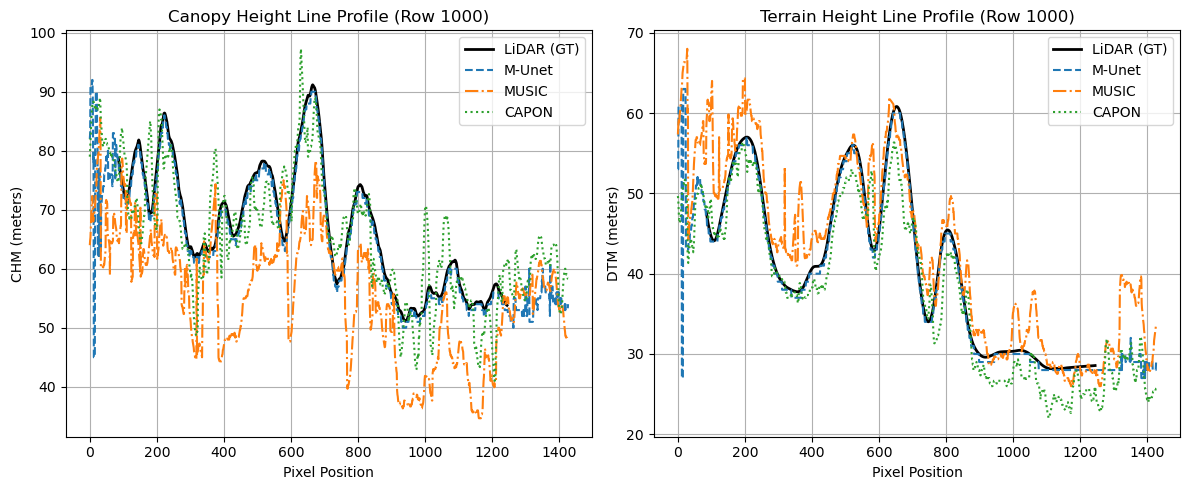

In [8]:
x = np.arange(gt_chm_line.shape[0])  # horizontal pixel positions

plt.figure(figsize=(12, 5))

# --- CHM plot ---
plt.subplot(1, 2, 1)
plt.plot(x, gt_chm_line, label='LiDAR (GT)', linewidth=2, color='black')
plt.plot(x, cnn_chm_line, label='M-Unet', linestyle='--')
if music_chm_line is not None:
    plt.plot(x, music_chm_line, label='MUSIC', linestyle='-.')
if capon_chm_line is not None:
    plt.plot(x, capon_chm_line, label='CAPON', linestyle=':')
plt.title(f'Canopy Height Line Profile (Row {row})')
plt.xlabel('Pixel Position')
plt.ylabel('CHM (meters)')
plt.legend()
plt.grid(True)

# --- DTM plot ---
plt.subplot(1, 2, 2)
plt.plot(x, gt_dtm_line, label='LiDAR (GT)', linewidth=2, color='black')
plt.plot(x, cnn_dtm_line, label='M-Unet', linestyle='--')
if music_dtm_line is not None:
    plt.plot(x, music_dtm_line, label='MUSIC', linestyle='-.')
if capon_dtm_line is not None:
    plt.plot(x, capon_dtm_line, label='CAPON', linestyle=':')
plt.title(f'Terrain Height Line Profile (Row {row})')
plt.xlabel('Pixel Position')
plt.ylabel('DTM (meters)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"line_profiles_row_{row}.png"), dpi=150)
plt.show()


In [9]:
def compute_line_metrics(pred_line, gt_line):
    mask = np.isfinite(pred_line) & np.isfinite(gt_line)
    if mask.sum() == 0:
        return {"rmse": np.nan, "mae": np.nan, "bias": np.nan, "count": 0}
    err = pred_line[mask] - gt_line[mask]
    return {
        "rmse": float(np.sqrt((err ** 2).mean())),
        "mae": float(np.abs(err).mean()),
        "bias": float(err.mean()),
        "count": int(mask.sum())
    }

# CHM
line_metrics = {
    "CNN_CHM": compute_line_metrics(cnn_chm_line, gt_chm_line),
    "MUSIC_CHM": compute_line_metrics(music_chm_line, gt_chm_line),
    "CAPON_CHM": compute_line_metrics(capon_chm_line, gt_chm_line),
    # DTM
    "CNN_DTM": compute_line_metrics(cnn_dtm_line, gt_dtm_line),
    "MUSIC_DTM": compute_line_metrics(music_dtm_line, gt_dtm_line),
    "CAPON_DTM": compute_line_metrics(capon_dtm_line, gt_dtm_line),
}

# Display nicely
import pandas as pd
df_line_metrics = pd.DataFrame.from_dict(line_metrics, orient='index')
print(df_line_metrics.round(3))


             rmse     mae    bias  count
CNN_CHM     1.073   0.995  -0.995   1161
MUSIC_CHM  14.244  12.737 -12.189   1161
CAPON_CHM   6.448   5.270  -1.409   1161
CNN_DTM     0.564   0.487  -0.487   1161
MUSIC_DTM   4.274   3.153   2.477   1161
CAPON_DTM   3.569   2.969  -2.386   1161


In [10]:
# Set output directory (adjust if needed)
line_out_dir = "test/test4"  # same as your previous output
os.makedirs(line_out_dir, exist_ok=True)

# Save to CSV
csv_path_line = os.path.join(line_out_dir, "metrics_line_transect.csv")
df_line_metrics.to_csv(csv_path_line, index_label="method")

print(f"Line transect metrics saved to:\n{csv_path_line}")


Line transect metrics saved to:
test/test4/metrics_line_transect.csv


# Loading TSNN model to compare with them

In [ ]:
!uv pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 60.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 56.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [pytorch-lightning]pytorch-lightning]


In [19]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [ ]:
# DATASET
class HeightDataset(Dataset):
    def __init__(self, X, yc=None, yg=None):
        self.X = X
        self.yc = yc
        self.yg = yg

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.yc is not None and self.yg is not None:
            return x, torch.tensor(self.yc[idx], dtype=torch.long), torch.tensor(self.yg[idx], dtype=torch.long)
        return x

# DATAMODULE 
class HeightDataModule(pl.LightningDataModule):
    def __init__(self, train_npz, val_npz, test_npz, scaler_path='tsnn_scaler.pkl', batch_size=32, num_workers=0):
        super().__init__()
        self.train_npz = train_npz
        self.val_npz = val_npz
        self.test_npz = test_npz
        self.scaler_path = scaler_path
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        # Fit scaler only
        if not os.path.exists(self.scaler_path):
            train_data = np.load(self.train_npz, mmap_mode='r')
            X = train_data['X']
            scaler = StandardScaler()
            for i in range(0, X.shape[0], 32):
                scaler.partial_fit(X[i:i+32])
            joblib.dump(scaler, self.scaler_path)
            print("Scaler fitted and saved!")
        else:
            print("Scaler already exists, skipping fit.")

    def setup(self, stage=None):
        scaler = joblib.load(self.scaler_path)

        train_data = np.load(self.train_npz)
        X_train = scaler.transform(train_data['X'])
        self.train_ds = HeightDataset(X_train, train_data['yc'], train_data['yg'])

        val_data = np.load(self.val_npz)
        X_val = scaler.transform(val_data['X'])
        self.val_ds = HeightDataset(X_val, val_data['yc'], val_data['yg'])

        test_data = np.load(self.test_npz)
        X_test = scaler.transform(test_data['X'])
        self.test_ds = HeightDataset(X_test, test_data['yc'], test_data['yg'])

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)


In [ ]:
class TSNN(nn.Module):
    def __init__(self, input_dim=52, num_classes=61, hidden=400, dropout_p=0.2):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden), nn.BatchNorm1d(hidden), nn.ReLU(), nn.Dropout(dropout_p)]
        for _ in range(7):
            layers.extend([nn.Linear(hidden, hidden), nn.BatchNorm1d(hidden), nn.ReLU(), nn.Dropout(dropout_p)])
        layers.extend([nn.Linear(hidden, hidden), nn.BatchNorm1d(hidden), nn.ReLU(), nn.Dropout(dropout_p)])
        layers.append(nn.Linear(hidden, num_classes))
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

#LIGHTNING MODULE
class TSNNLitModule(pl.LightningModule):
    def __init__(self, input_dim=52, num_classes_c=61, num_classes_g=41, hidden=400, dropout_p=0.2, lr=5e-5, wd=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model_c = TSNN(input_dim, num_classes_c, hidden, dropout_p)
        self.model_g = TSNN(input_dim, num_classes_g, hidden, dropout_p)
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.wd = wd

    def forward(self, x):
        return self.model_c(x), self.model_g(x)

    def training_step(self, batch, batch_idx):
        x, yc, yg = batch
        pred_c = self.model_c(x)
        pred_g = self.model_g(x)
        loss_c = self.criterion(pred_c, yc)
        loss_g = self.criterion(pred_g, yg)
        loss = loss_c + loss_g
        self.log('train/loss_c', loss_c, prog_bar=True)
        self.log('train/loss_g', loss_g, prog_bar=True)
        self.log('train/loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, yc, yg = batch
        pred_c = self.model_c(x)
        pred_g = self.model_g(x)
        loss_c = self.criterion(pred_c, yc)
        loss_g = self.criterion(pred_g, yg)
        loss = loss_c + loss_g
        self.log('val/loss_c', loss_c, prog_bar=True)
        self.log('val/loss_g', loss_g, prog_bar=True)
        self.log('val/loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, yc, yg = batch
        pred_c = self.model_c(x)
        pred_g = self.model_g(x)
        loss_c = self.criterion(pred_c, yc)
        loss_g = self.criterion(pred_g, yg)
        loss = loss_c + loss_g
        self.log('test/loss_c', loss_c, prog_bar=True)
        self.log('test/loss_g', loss_g, prog_bar=True)
        self.log('test/loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(list(self.model_c.parameters()) + list(self.model_g.parameters()), lr=self.lr, weight_decay=self.wd)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val/loss"}}

    def on_before_zero_grad(self, optimizer):
        clip_grad_norm_(self.model_c.parameters(), 1.0)
        clip_grad_norm_(self.model_g.parameters(), 1.0)

In [22]:
import numpy as np

train = np.load("TSNN_Model/train_data.npz")
print("CHM min/max:", train["yc"].min(), train["yc"].max())
print("DTM min/max:", train["yg"].min(), train["yg"].max())

CHM min/max: 46 60
DTM min/max: 28 40


## Test TSNN Model

In [23]:
from glob import glob

ckpts = glob('TSNN_Model/best-tsnn.ckpt')
print(ckpts)
best_ckpt_path = ckpts[0]
print("Best checkpoint path:", best_ckpt_path)

['TSNN_Model/best-tsnn.ckpt']
Best checkpoint path: TSNN_Model/best-tsnn.ckpt


In [24]:
data = HeightDataModule(
    train_npz='TSNN_Model/train_data.npz',
    val_npz='TSNN_Model/val_data.npz',
    test_npz='TSNN_Model/test_labeled_data.npz',
    scaler_path='TSNN_Model/tsnn_scaler.pkl',
    batch_size=32,
    num_workers=0
)

In [ ]:
from sklearn.metrics import accuracy_score
import torch

model = TSNNLitModule.load_from_checkpoint(best_ckpt_path)

trainer = pl.Trainer(accelerator='auto', devices='auto')
trainer.test(model, datamodule=data)

## test
model = TSNNLitModule.load_from_checkpoint(best_ckpt_path)


data = HeightDataModule(
    train_npz='TSNN_Model/train_data.npz',
    val_npz='TSNN_Model/val_data.npz',
    test_npz='TSNN_Model/test_labeled_data.npz',
    scaler_path='TSNN_Model/tsnn_scaler.pkl',
    batch_size=32,
    num_workers=0
)
data.setup()
test_loader = data.test_dataloader()

device = model.device if hasattr(model, 'device') else next(model.parameters()).device

all_preds_c, all_preds_g = [], []
all_yc, all_yg = [], []

model.eval()
with torch.no_grad():
    for x, yc, yg in test_loader:
        # Move data to the same device as the model
        x = x.to(device)
        yc = yc.to(device)
        yg = yg.to(device)

        pred_c, pred_g = model(x)
        all_preds_c.append(torch.argmax(pred_c, dim=1).cpu())  # Move to cpu for numpy later
        all_preds_g.append(torch.argmax(pred_g, dim=1).cpu())
        all_yc.append(yc.cpu())
        all_yg.append(yg.cpu())


# Concatenate all batches
all_preds_c = torch.cat(all_preds_c).cpu().numpy()
all_preds_g = torch.cat(all_preds_g).cpu().numpy()
all_yc = torch.cat(all_yc).cpu().numpy()
all_yg = torch.cat(all_yg).cpu().numpy()

print ("acuuracy yc:", accuracy_score(all_yc, all_preds_c))
print ("acuuracy yg:", accuracy_score(all_yg, all_preds_g))

## Visualization

In [ ]:
import h5py
import numpy as np

mat_path = 'DataSets/Covariance_matrices_fullpol.mat'

with h5py.File(mat_path, 'r') as f:
    cov_raw = f['covariance'][:]  # shape: (1428, 2450, 18, 18)

# Reconstruct complex array: cov_raw is structured dtype
real = cov_raw['real']
imag = cov_raw['imag']
cov_complex = real + 1j * imag  # shape: (1428, 2450, 18, 18)

# Transpose to match CHM/DTM
cov_complex = np.transpose(cov_complex, (1, 0, 2, 3))  # shape: (2450, 1428, 18, 18)
H, W = 2450, 1428
features = np.zeros((H, W, 52), dtype=np.float32)

for i in range(H):
    for j in range(W):
        cov = cov_complex[i, j]  # shape (18, 18)

        # 18 real diagonal elements
        diag_real = np.real(np.diag(cov))

        # 17 off-diagonal from first row (cols 1–17)
        off_diag = cov[0, 1:18]
        off_real = np.real(off_diag)
        off_imag = np.imag(off_diag)

        vec = np.concatenate([diag_real, off_real, off_imag])  # 52-dim
        features[i, j, :] = vec

X = features.reshape(-1, 52)

# Normalize
import joblib
scaler = joblib.load("TSNN_Model/tsnn_scaler.pkl")
X_scaled = scaler.transform(X)

In [ ]:

from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(torch.tensor(X_scaled, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=32)

#import TSNNLitModule  
model = TSNNLitModule.load_from_checkpoint("TSNN_Model/best-tsnn.ckpt")
model.eval().cuda()

pred_c, pred_g = [], []
with torch.no_grad():
    for batch in loader:
        x = batch[0].cuda()
        pc, pg = model(x)
        pred_c.append(torch.argmax(pc, dim=1).cpu())
        pred_g.append(torch.argmax(pg, dim=1).cpu())

# Reshape to (H, W)
pred_c = torch.cat(pred_c).numpy().reshape(H, W)
pred_g = torch.cat(pred_g).numpy().reshape(H, W)

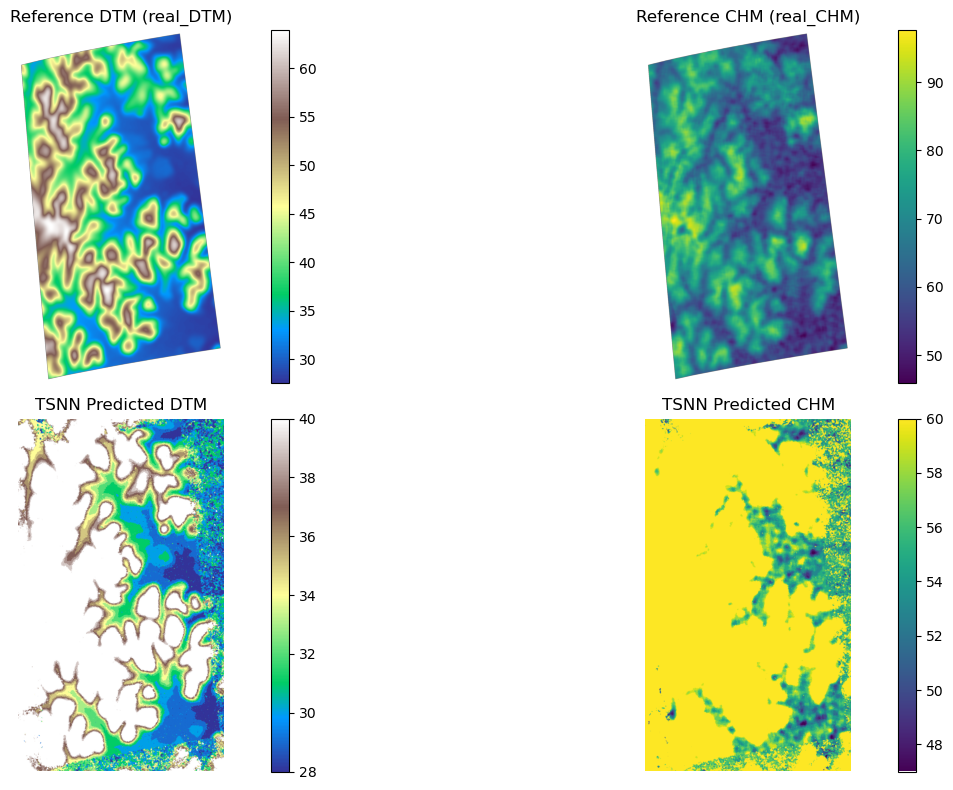

In [ ]:
# --- Step 1: Load .mat reference images ---
mat_data = scipy.io.loadmat('DataSets/dataset_Guiana_6FPimages_Pband.mat')
CHM = mat_data['CHM']
DTM = mat_data['DTM']
real_DTM = DTM + 25
real_CHM = DTM + CHM + 25


# --- Step 5: Visualize ---
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.imshow(real_DTM, cmap='terrain')
plt.title('Reference DTM (real_DTM)')
plt.axis('off')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(real_CHM, cmap='viridis')
plt.title('Reference CHM (real_CHM)')
plt.axis('off')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(pred_g, cmap='terrain')
plt.title('TSNN Predicted DTM')
plt.axis('off')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(pred_c, cmap='viridis')  
plt.title('TSNN Predicted CHM')
plt.axis('off')
plt.colorbar()



plt.tight_layout()
#plt.savefig("test/TSNN_DTM_CHM_pred.png", dpi=300)
plt.show()



## Plotting Visual Line for all choosing the middle row in the data

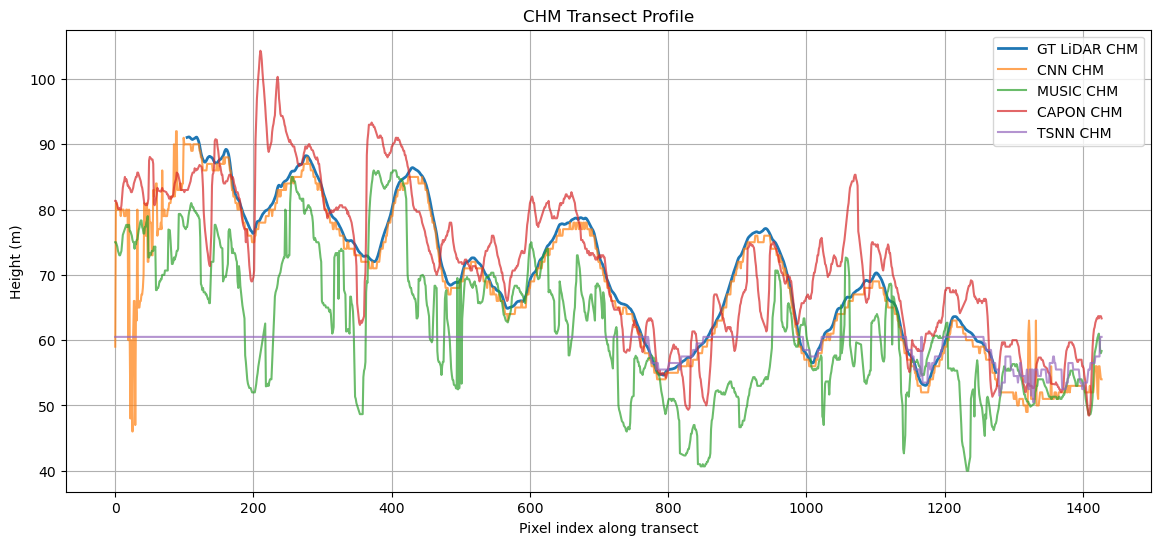

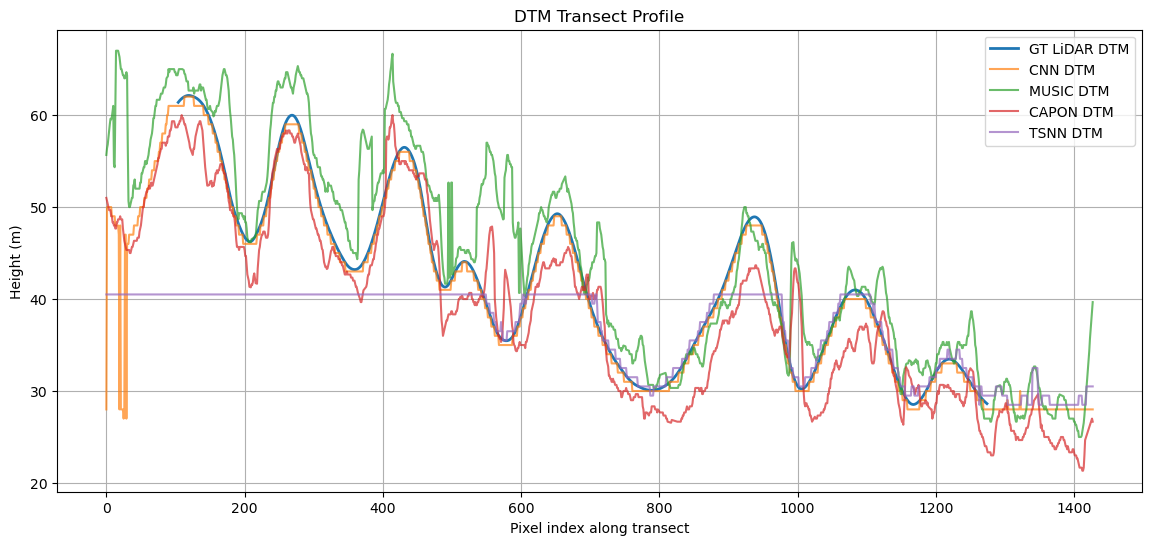

In [44]:
import matplotlib.pyplot as plt

x_axis = np.arange(W)  # pixel positions along the row

# --- CHM profile ---
plt.figure(figsize=(14,6))
plt.plot(x_axis, gt_chm_line, label="GT LiDAR CHM", linewidth=2)
plt.plot(x_axis, cnn_chm_line, label="CNN CHM", alpha=0.7)
plt.plot(x_axis, music_chm_line, label="MUSIC CHM", alpha=0.7)
plt.plot(x_axis, capon_chm_line, label="CAPON CHM", alpha=0.7)
plt.plot(x_axis, tsnn_chm_line, label="TSNN CHM", alpha=0.7)
plt.xlabel("Pixel index along transect")
plt.ylabel("Height (m)")
plt.title("CHM Transect Profile")
plt.legend()
plt.grid(True)
plt.show()

# --- DTM profile ---
plt.figure(figsize=(14,6))
plt.plot(x_axis, gt_dtm_line, label="GT LiDAR DTM", linewidth=2)
plt.plot(x_axis, cnn_dtm_line, label="CNN DTM", alpha=0.7)
plt.plot(x_axis, music_dtm_line, label="MUSIC DTM", alpha=0.7)
plt.plot(x_axis, capon_dtm_line, label="CAPON DTM", alpha=0.7)
plt.plot(x_axis, tsnn_dtm_line, label="TSNN DTM", alpha=0.7)
plt.xlabel("Pixel index along transect")
plt.ylabel("Height (m)")
plt.title("DTM Transect Profile")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# === Utility functions ===
def compute_errors(pred, gt):
    mask = ~np.isnan(gt)
    if mask.sum() == 0:
        return {"rmse": np.nan, "mae": np.nan, "bias": np.nan}
    diff = pred[mask] - gt[mask]
    rmse = np.sqrt(np.mean(diff**2))
    mae  = np.mean(np.abs(diff))
    bias = np.mean(diff)
    return {"rmse": rmse, "mae": mae, "bias": bias}

def plot_transect(gt_line, preds_dict, title, save_path):
    x_axis = np.arange(len(gt_line))
    plt.figure(figsize=(14,6))
    plt.plot(x_axis, gt_line, label="GT LiDAR", linewidth=2)
    for k,v in preds_dict.items():
        plt.plot(x_axis, v, label=k, alpha=0.8)
    plt.xlabel("Pixel index along transect")
    plt.ylabel("Height (m)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.close()

# === Choose transect (middle row) ===
row = H // 2   # middle row

# Ground truth
gt_chm_line = CHM_real[row, :]
gt_dtm_line = DTM_real[row, :]

# CNN
cnn_chm_line = CNN_CHM_real[row, :]
cnn_dtm_line = CNN_DTM_real[row, :]

# MUSIC
music_chm_line = MUSIC_chm_raw[row, :]
music_dtm_line = MUSIC_dtm_raw[row, :]

# CAPON
capon_chm_line = CAPON_chm_raw[row, :]
capon_dtm_line = CAPON_dtm_raw[row, :]

# TSNN (preds are class indices, shift +0.5 to get bin centers)
tsnn_chm_line = pred_c[row, :] + 0.5
tsnn_dtm_line = pred_g[row, :] + 0.5

# === Save results ===
out_dir = "test/transect_results"
os.makedirs(out_dir, exist_ok=True)

# CHM transect
plot_transect(gt_chm_line, {
    "M-Unet CHM": cnn_chm_line,
    "MUSIC CHM": music_chm_line,
    "CAPON CHM": capon_chm_line,
    "TSNN CHM": tsnn_chm_line
}, "CHM Transect Profile", os.path.join(out_dir, "transect_chm.png"))

# DTM transect
plot_transect(gt_dtm_line, {
    "M-Unet DTM": cnn_dtm_line,
    "MUSIC DTM": music_dtm_line,
    "CAPON DTM": capon_dtm_line,
    "TSNN DTM": tsnn_dtm_line
}, "DTM Transect Profile", os.path.join(out_dir, "transect_dtm.png"))

# === Compute errors ===
records = []
for name, pred in {
    "M-Unet CHM": cnn_chm_line,
    "MUSIC CHM": music_chm_line,
    "CAPON CHM": capon_chm_line,
    "TSNN CHM": tsnn_chm_line
}.items():
    e = compute_errors(pred, gt_chm_line)
    records.append({"Model": name, "Type": "CHM", **e})

for name, pred in {
    "M-Unet DTM": cnn_dtm_line,
    "MUSIC DTM": music_dtm_line,
    "CAPON DTM": capon_dtm_line,
    "TSNN DTM": tsnn_dtm_line
}.items():
    e = compute_errors(pred, gt_dtm_line)
    records.append({"Model": name, "Type": "DTM", **e})

# Save table
df = pd.DataFrame(records)
df.to_csv(os.path.join(out_dir, "transect_errors.csv"), index=False)
print("Saved plots and errors to:", out_dir)
print(df)


Saved plots and errors to: test/transect_results
        Model Type       rmse        mae       bias
0  M-Unet CHM  CHM   1.087065   1.007521  -1.007521
1   MUSIC CHM  CHM  12.306924  10.096227  -8.913442
2   CAPON CHM  CHM   7.187085   5.553747   2.200848
3    TSNN CHM  CHM  14.268574  11.158129 -10.904617
4  M-Unet DTM  DTM   0.577436   0.499076  -0.498433
5   MUSIC DTM  DTM   5.541764   3.946095   3.360519
6   CAPON DTM  DTM   3.988661   3.410303  -2.259891
7    TSNN DTM  DTM   7.833757   4.959007  -4.385282


# Display ALL together

GT shapes: (2450, 1428) (2450, 1428)
Loaded CNN preds from: predictions_unlabeled/predictions_unlabeled_with_uncertainty.npz
Using in-memory pred_c / pred_g for TSNN
Heuristic: CNN CHM looks relative; will convert to absolute using SHIFT (+25).
MUSIC shapes: (2450, 1428)
CAPON shapes: (2450, 1428)
Will display CHM: ['GT', 'CNN', 'TSNN', 'MUSIC', 'CAPON']
Will display DTM: ['GT', 'CNN', 'TSNN', 'MUSIC', 'CAPON']


/tmp/ipykernel_2222/1751816511.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


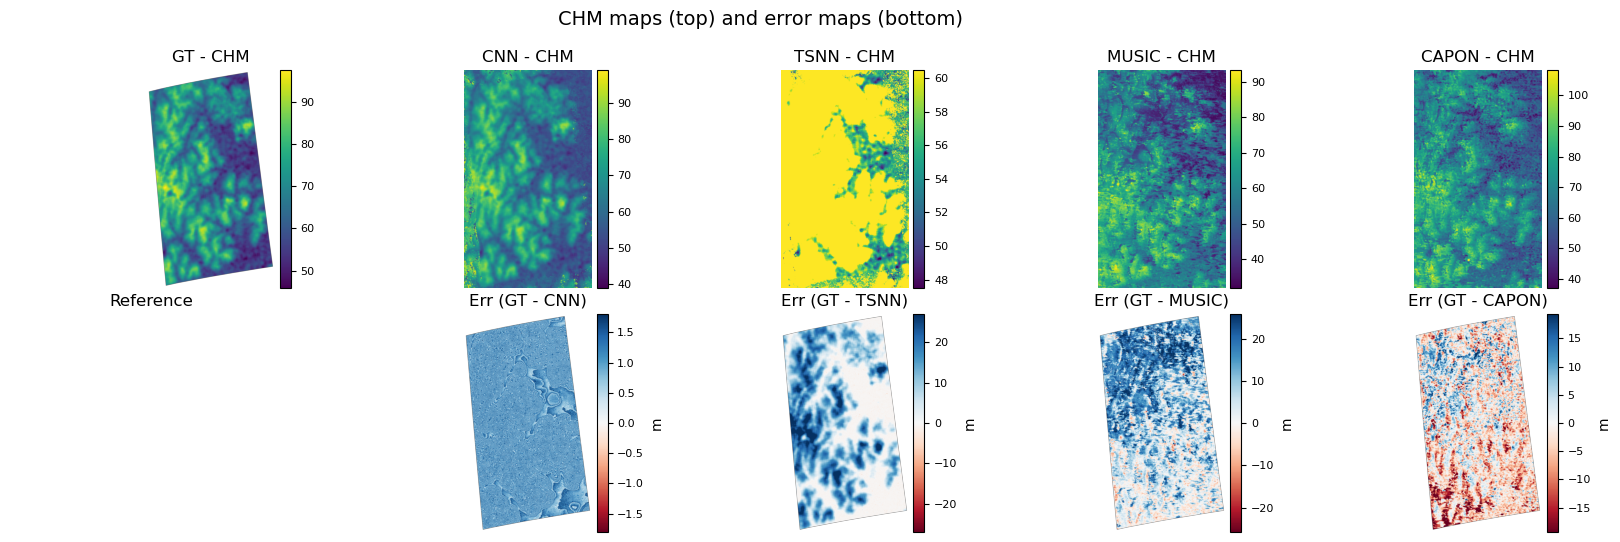

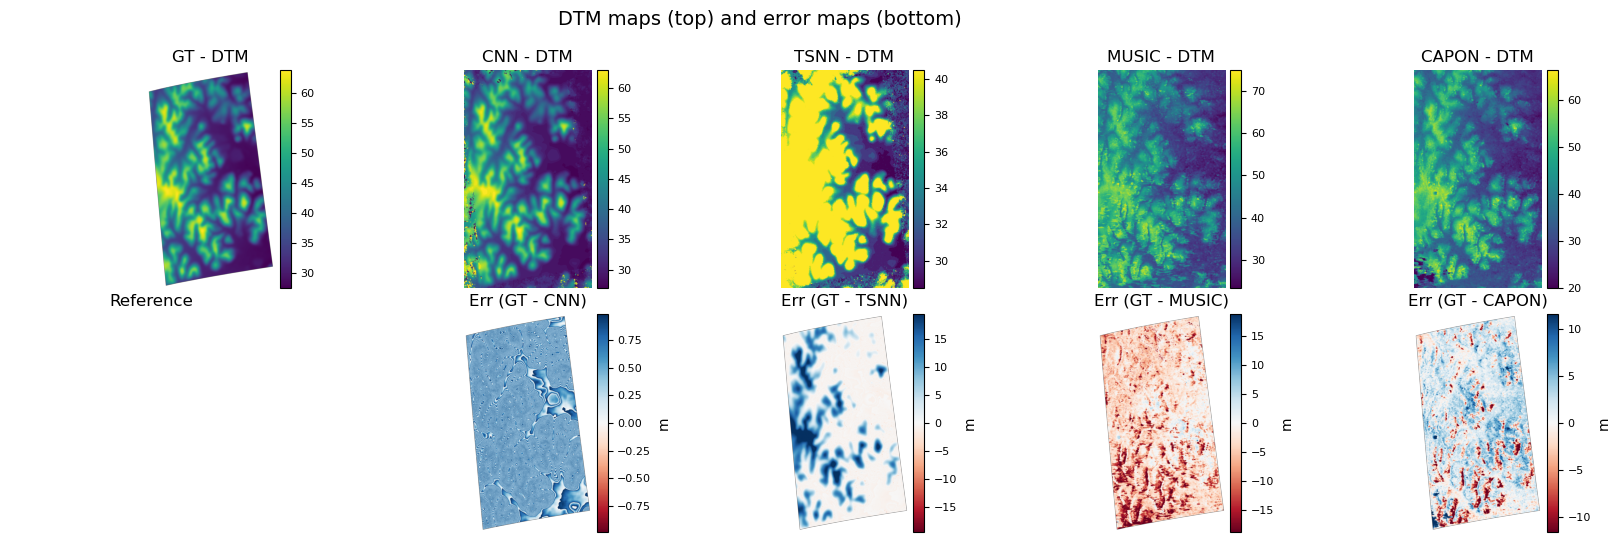

Saved montage to: test/test12/overview_CHM_DTM_no_clip.png
Saved metrics CSV to: test/test12/comparison_metrics_chm_dtm_canopy.csv


source variable  reference       rmse        mae       bias    count
0      GT      CHM    GT_real   0.000000   0.000000   0.000000  2555060
1     CNN      CHM    GT_real   1.079259   0.997777  -0.997712  2555060
2    TSNN      CHM    GT_real  12.275260   9.185355  -8.905140  2555060
3   MUSIC      CHM    GT_real  12.614684  10.033870  -8.838491  2555060
4   CAPON      CHM    GT_real   7.649497   5.893505   1.673226  2555060
5      GT      DTM    GT_real   0.000000   0.000000   0.000000  2555060
6     CNN      DTM    GT_real   0.577758   0.499935  -0.499213  2555060
7    TSNN      DTM    GT_real   7.114720   4.355483  -3.771540  2555060
8   MUSIC      DTM    GT_real   6.987821   5.133546   4.943580  2555060
9   CAPON      DTM    GT_real   4.114496   3.011088  -0.965534  2555060
10  MUSIC   Canopy  GT_canopy  16.081494  14.033719 -13.782071  2555060
11     GT   Canopy  GT_canopy   0.000000   0.000000   0.000000  2555060
12  CAPON   Canopy  GT_canopy   8.626849   6.606277   2.638760  2555060
13   TSNN   Canopy  GT_canopy   6.611199   5.313490  -5.133600  2555060
14    CNN   Canopy  GT_canopy   0.577265   0.499256  -0.498499  2555060

Done. If a method is missing from the visuals, check the file paths and rerun this cell.


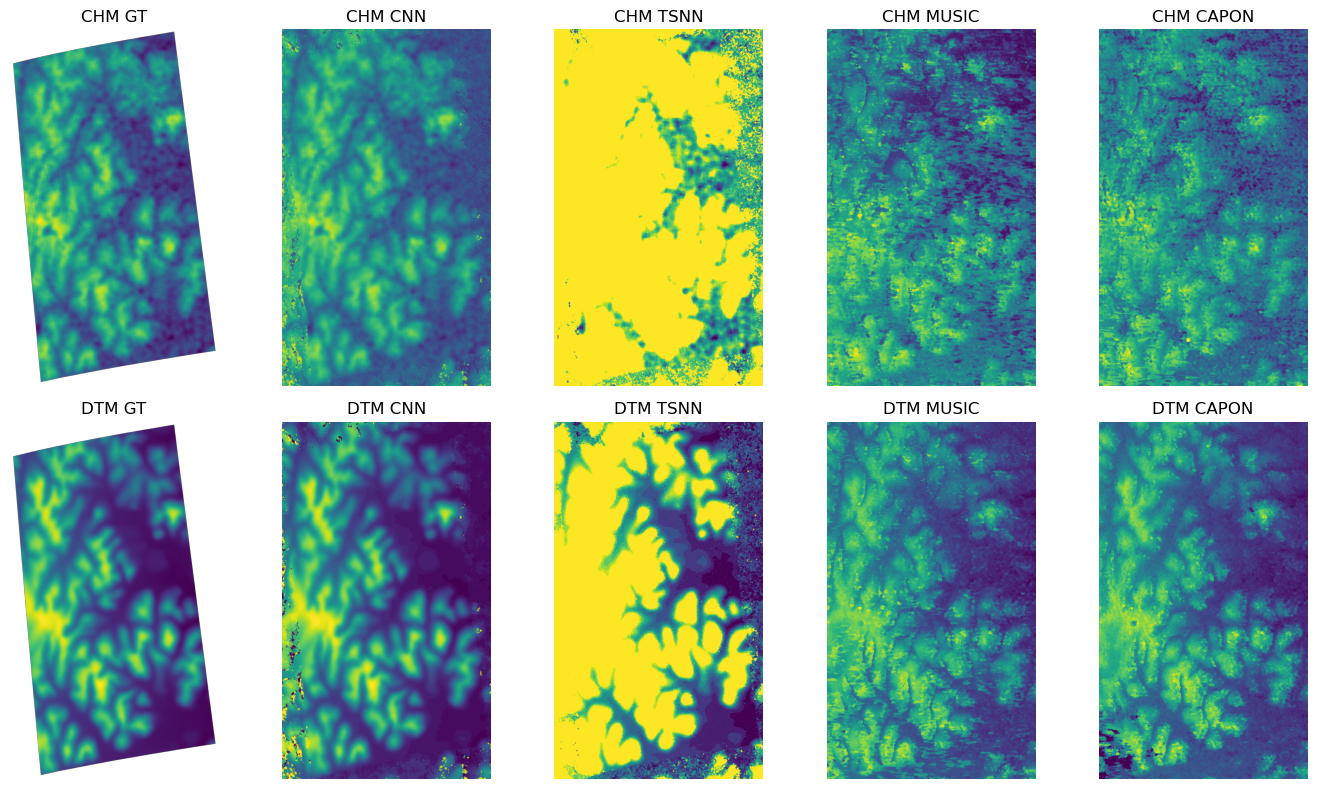

In [ ]:
#  Visualization & metrics cell
import os, math
import numpy as np
import scipy.io
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.ndimage import zoom
from IPython.display import display

# paths
GT_MAT     = "DataSets/dataset_Guiana_6FPimages_Pband.mat"   # GT LiDAR
PRED_NPZ1  = "predictions_unlabeled/predictions_unlabeled_with_uncertainty.npz"                      # possible CNN preds
PRED_NPZ2  = "predictions_unlabeled/predictions_unlabeled_with_uncertainty.npz"
TSNN_NPZ   = "TSNN_Model/tsnn_preds.npz"                             # TSNN saved preds (pred_c,pred_g)
MUSIC_MAT  = "TM/MUSIC_Height_FullScene.mat"
CAPON_MAT  = "TM/CAPON_Height_FullScene.mat"
OUT_DIR    = "test/test12"
os.makedirs(OUT_DIR, exist_ok=True)

# PARAMETERS 
SHIFT = 25.0   # +25 (GT real heights)

def rmse_mae_bias(pred, gt):
    mask = np.isfinite(pred) & np.isfinite(gt)
    if mask.sum() == 0:
        return (np.nan, np.nan, np.nan, 0)
    err = pred[mask].astype(np.float64) - gt[mask].astype(np.float64)
    return (math.sqrt((err**2).mean()), float(np.mean(np.abs(err))), float(np.mean(err)), int(mask.sum()))

def load_mat_v73(path):
    if not os.path.exists(path):
        return {}
    d = {}
    with h5py.File(path, 'r') as f:
        for k in f.keys():
            try:
                d[k] = np.array(f[k])
            except Exception:
                pass
    return d

def avg_chm_dtm_from_matdict(d):
    if not d:
        return None, None
    keys = list(d.keys())
    chm_keys = [k for k in keys if 'chm' in k.lower()]
    dtm_keys = [k for k in keys if 'dtm' in k.lower()]
    def avg_list(kl):
        if not kl: return None
        arrs = []
        ref = None
        for k in kl:
            try:
                a = np.array(d[k], dtype=np.float64)
            except Exception:
                continue
            if ref is None: ref = a.shape
            if a.shape == ref:
                arrs.append(a)
            elif a.T.shape == ref:
                arrs.append(a.T)
            elif a.size == ref[0]*ref[1]:
                arrs.append(a.reshape(ref))
        if not arrs: return None
        return np.mean(np.stack(arrs, axis=0), axis=0)
    return avg_list(chm_keys), avg_list(dtm_keys)

def align_to_ref(a, ref):
    if a is None: return None
    a = np.array(a, dtype=np.float64)
    if a.shape == ref.shape: return a
    if a.T.shape == ref.shape: return a.T
    if a.size == ref.size: return a.reshape(ref.shape)
    return zoom(a, (ref.shape[0]/a.shape[0], ref.shape[1]/a.shape[1]), order=1)

#   GT & build GT_real
if not os.path.exists(GT_MAT):
    raise FileNotFoundError(f"GT MAT not found: {GT_MAT}")
mat = scipy.io.loadmat(GT_MAT)
CHM_rel = np.array(mat['CHM'], dtype=np.float64)   # relative canopy
DTM_rel = np.array(mat['DTM'], dtype=np.float64)   # relative ground
H, W = CHM_rel.shape
DTM_real = DTM_rel + SHIFT                # absolute ground
CHM_real = DTM_rel + CHM_rel + SHIFT      # absolute canopy (GT)

print("GT shapes:", CHM_rel.shape, DTM_rel.shape)

# CNN predictions
cnn_chm = None; cnn_dtm = None
for p in (PRED_NPZ1, PRED_NPZ2):
    if os.path.exists(p):
        d = dict(np.load(p, allow_pickle=True))
        # continuous preds
        cnn_chm = d.get('pred_chm_cont', d.get('pred_chm_map', None))
        cnn_dtm = d.get('pred_dtm_cont', d.get('pred_dtm_map', None))
        print("Loaded CNN preds from:", p)
        break

if cnn_chm is None or cnn_dtm is None:
    print("CNN pred npz not found or missing keys. Expected pred_chm_cont/pred_dtm_cont or pred_*_map in:", PRED_NPZ1, PRED_NPZ2)
else:
    cnn_chm = np.array(cnn_chm, dtype=np.float64)
    cnn_dtm = np.array(cnn_dtm, dtype=np.float64)
    cnn_chm = align_to_ref(cnn_chm, CHM_real)
    cnn_dtm = align_to_ref(cnn_dtm, DTM_real)

#  TSNN predictions
tsnn_c = None; tsnn_g = None
if os.path.exists(TSNN_NPZ):
    dts = dict(np.load(TSNN_NPZ, allow_pickle=True))
    tsnn_c = dts.get('pred_c', None)
    tsnn_g = dts.get('pred_g', None)
    if tsnn_c is not None:
        tsnn_c = np.array(tsnn_c, dtype=np.float64).reshape(H, W)
    if tsnn_g is not None:
        tsnn_g = np.array(tsnn_g, dtype=np.float64).reshape(H, W)
    print("Loaded TSNN preds from:", TSNN_NPZ)
else:
    if 'pred_c' in globals() and 'pred_g' in globals():
        pc = globals()['pred_c']; pg = globals()['pred_g']
        try:
            import torch
            if isinstance(pc, torch.Tensor): pc = pc.cpu().numpy()
            if isinstance(pg, torch.Tensor): pg = pg.cpu().numpy()
        except Exception:
            pass
        tsnn_c = np.array(pc, dtype=np.float64).reshape(H, W)
        tsnn_g = np.array(pg, dtype=np.float64).reshape(H, W)
        print("Using in-memory pred_c / pred_g for TSNN")
    else:
        print("No TSNN preds found (set TSNN_NPZ or provide pred_c/pred_g in memory).")


CNN_is_relative = False
if cnn_chm is not None:
    # if max CHM ~< 60 and min >=0 assume relative
    if np.nanmax(cnn_chm) <= 60 and np.nanmin(cnn_chm) >= -1e-6:
        CNN_is_relative = True
        print("Heuristic: CNN CHM looks relative; will convert to absolute using SHIFT (+25).")
    else:
        print("Heuristic: CNN CHM looks absolute; will not add SHIFT.")

if cnn_chm is not None:
    if CNN_is_relative:
        CNN_DTM_real = cnn_dtm + SHIFT
        CNN_CHM_real = cnn_dtm + cnn_chm + SHIFT
    else:
        #  cnn_chm/dtm are  absolute values (like MUSIC/CAPON)
        CNN_DTM_real = cnn_dtm
        CNN_CHM_real = cnn_chm

#  MUSIC/CAPON
music_dict = load_mat_v73(MUSIC_MAT)
capon_dict = load_mat_v73(CAPON_MAT)
MUSIC_chm_raw, MUSIC_dtm_raw = avg_chm_dtm_from_matdict(music_dict)
CAPON_chm_raw, CAPON_dtm_raw = avg_chm_dtm_from_matdict(capon_dict)
MUSIC_chm_raw = align_to_ref(MUSIC_chm_raw, CHM_real) if MUSIC_chm_raw is not None else None
MUSIC_dtm_raw = align_to_ref(MUSIC_dtm_raw, DTM_real) if MUSIC_dtm_raw is not None else None
CAPON_chm_raw = align_to_ref(CAPON_chm_raw, CHM_real) if CAPON_chm_raw is not None else None
CAPON_dtm_raw = align_to_ref(CAPON_dtm_raw, DTM_real) if CAPON_dtm_raw is not None else None

print("MUSIC shapes:", None if MUSIC_chm_raw is None else MUSIC_chm_raw.shape)
print("CAPON shapes:", None if CAPON_chm_raw is None else CAPON_chm_raw.shape)

# Build display dictionaries
display_chm = {'GT': CHM_real}
display_dtm = {'GT': DTM_real}
if 'CNN_CHM_real' in locals():
    display_chm['CNN'] = CNN_CHM_real
    display_dtm['CNN'] = CNN_DTM_real
if tsnn_c is not None:
    # TSNN predicted classes
    if np.allclose(np.round(tsnn_c), tsnn_c): tsnn_chm_cont = tsnn_c + 0.5
    else: tsnn_chm_cont = tsnn_c
    if np.allclose(np.round(tsnn_g), tsnn_g): tsnn_dtm_cont = tsnn_g + 0.5
    else: tsnn_dtm_cont = tsnn_g
    display_chm['TSNN'] = tsnn_chm_cont
    display_dtm['TSNN'] = tsnn_dtm_cont
if MUSIC_chm_raw is not None:
    display_chm['MUSIC'] = MUSIC_chm_raw
    display_dtm['MUSIC'] = MUSIC_dtm_raw
if CAPON_chm_raw is not None:
    display_chm['CAPON'] = CAPON_chm_raw
    display_dtm['CAPON'] = CAPON_dtm_raw

print("Will display CHM:", list(display_chm.keys()))
print("Will display DTM:", list(display_dtm.keys()))

# displaying
def display_maps_and_errors(methods_dict, GT_arr, varname="CHM"):
    names = list(methods_dict.keys())
    n = len(names)
    fig = plt.figure(figsize=(4*n, 6))
    gs = gridspec.GridSpec(2, n, height_ratios=[1,1], hspace=0.12, wspace=0.12)


    for i, name in enumerate(names):
        ax = fig.add_subplot(gs[0, i])
        arr = methods_dict[name]
        im = ax.imshow(arr)            # no global vmin/vmax
        ax.set_title(f"{name} - {varname}")
        ax.axis('off')
        cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
        cb.ax.tick_params(labelsize=8)

    # symmetric error maps (GT - method)
    for i, name in enumerate(names):
        ax = fig.add_subplot(gs[1, i])
        if name == 'GT':
            ax.axis('off'); ax.set_title("Reference"); continue
        arr = methods_dict[name]
        err = GT_arr - arr
        # robust symmetric limits
        mag = np.nanpercentile(np.abs(err), 98)
        if (not np.isfinite(mag)) or mag == 0:
            mag = np.nanpercentile(np.abs(err[~np.isnan(err)]), 90) if np.any(~np.isnan(err)) else 1.0
        plot_vmin, plot_vmax = -mag, mag
        im = ax.imshow(err, cmap='RdBu', vmin=plot_vmin, vmax=plot_vmax)
        ax.set_title(f"Err (GT - {name})")
        ax.axis('off')
        cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
        cb.set_label("m")
        cb.ax.tick_params(labelsize=8)

    plt.suptitle(f"{varname} maps (top) and error maps (bottom)", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

# Display CHM and DTM maps
display_maps_and_errors(display_chm, CHM_real, varname="CHM")
display_maps_and_errors(display_dtm, DTM_real, varname="DTM")

# Save summary
try:
    montage_path = os.path.join(OUT_DIR, "overview_CHM_DTM_no_clip.png")
    fig2 = plt.figure(figsize=(14,8))
    keys_chm = list(display_chm.keys())[:5]
    keys_dtm = list(display_dtm.keys())[:5]
    for i, k in enumerate(keys_chm):
        ax = fig2.add_subplot(2, 5, i+1)
        ax.imshow(display_chm[k]); ax.set_title(f"CHM {k}"); ax.axis('off')
    for i, k in enumerate(keys_dtm):
        ax = fig2.add_subplot(2, 5, 5 + i + 1)
        ax.imshow(display_dtm[k]); ax.set_title(f"DTM {k}"); ax.axis('off')
    plt.tight_layout()
    plt.savefig(montage_path, dpi=160, bbox_inches='tight')
    print("Saved montage to:", montage_path)
except Exception as e:
    print("Montage save failed:", e)

#  metrics and save to CSV
rows = []
def add_metric_row(source, var, ref_name, ref_arr, pred_arr):
    if pred_arr is None: return
    r = rmse_mae_bias(pred_arr, ref_arr)
    rows.append({"source":source, "variable":var, "reference":ref_name,
                 "rmse":r[0], "mae":r[1], "bias":r[2], "count":r[3]})

# CHM & DTM comparisons vs GT_real
for name, arr in display_chm.items():
    add_metric_row(name, "CHM", "GT_real", CHM_real, arr)
for name, arr in display_dtm.items():
    add_metric_row(name, "DTM", "GT_real", DTM_real, arr)

# Canopy (CHM - DTM) comparisons vs GT canopy (CHM_real - DTM_real)
GT_canopy = CHM_real - DTM_real
for name in set(display_chm.keys()) & set(display_dtm.keys()):
    pred_canopy = display_chm[name] - display_dtm[name]
    add_metric_row(name, "Canopy", "GT_canopy", GT_canopy, pred_canopy)

df = pd.DataFrame(rows)
csv_path = os.path.join(OUT_DIR, "comparison_metrics_chm_dtm_canopy.csv")
df.to_csv(csv_path, index=False)
print("Saved metrics CSV to:", csv_path)
display(df)

print("Done")


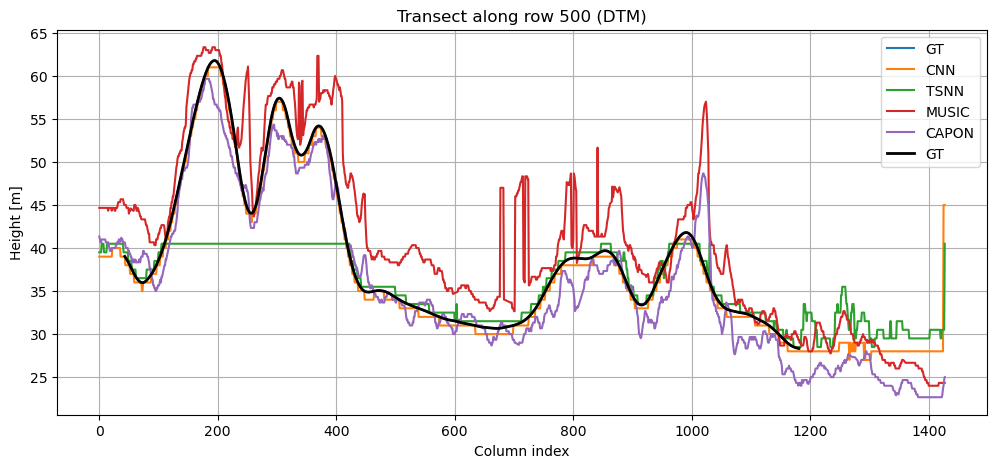

In [ ]:
#Dynamic transect line plot
import matplotlib.pyplot as plt

def plot_transect(row_idx=None,save_path = None, var="CHM", also_csv=False):
    """
    row_idx : int or None
        If None, will use middle row. Otherwise plot the given row index.
    var : "CHM" or "DTM"
    """
    if var not in ["CHM","DTM"]:
        raise ValueError("var must be 'CHM' or 'DTM'")

    ref = CHM_real if var=="CHM" else DTM_real
    names = list(display_chm.keys()) if var=="CHM" else list(display_dtm.keys())
    methods_dict = display_chm if var=="CHM" else display_dtm

    if row_idx is None:
        row_idx = ref.shape[0]//2

    plt.figure(figsize=(12,5))
    for name in names:
        arr = methods_dict[name]
        if arr is None: continue
        plt.plot(arr[row_idx, :], label=name)

    plt.plot(ref[row_idx, :], label="GT", color="black", linewidth=2)
    plt.title(f"Transect along row {row_idx} ({var})")
    plt.xlabel("Column index")
    plt.ylabel("Height [m]")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_transect(150, "CHM")
plot_transect(500, "DTM")
#plot_transect(None, "CHM")   # default: middle row CHM


Saved figure to test/test12/transect_row700_CHM.png


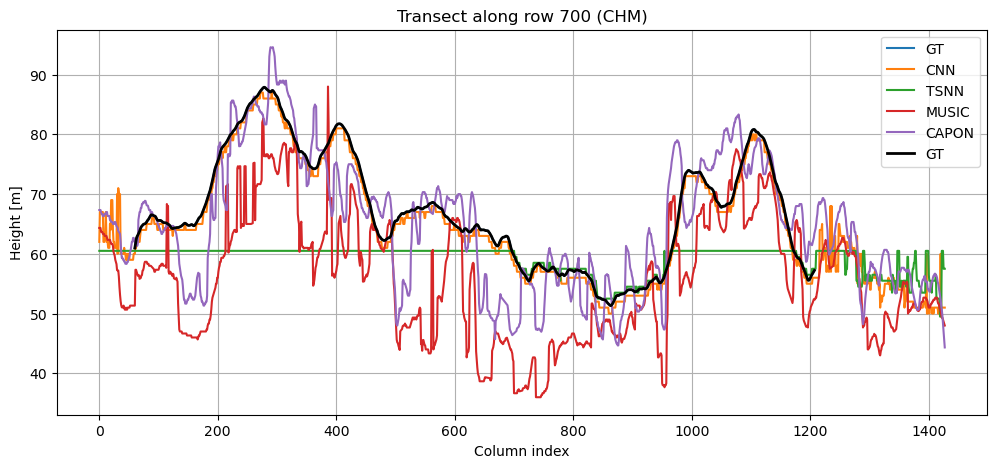

Saved transect data to test/test12/transect_row700_CHM.csv


In [86]:
plot_transect(700, "CHM", save_path="test/test12/transect_row700_CHM.png", also_csv=True)